In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_11887/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


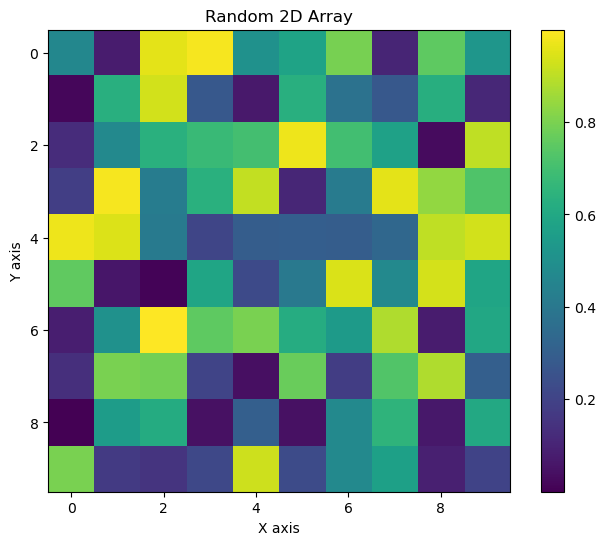

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad) # learning parameter 개수
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board ########################
# decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save


# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "3",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 8 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'NMNIST_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = decay, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = decay, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 25_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = True, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': 'my_snn_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
    'parameters': 
    {
        "learning_rate": {"min": 0.0001, "max": 0.01},
        "BATCH": {"values": [8,16,32,64,96,128]},
        "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [5,6,7,8,9,10]},
        "epoch_num": {"values": [20]},
        "dvs_duration": {"values": [10_000, 100_000, 25_000, 50_000]},
        "dvs_clipping": {"values": [0,1,2,4]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [True, False]},
        "surrogate": {"values": ['rectangle', 'sigmoid']},
        "cfg": {"values": [['M','M',200,200]]},
        "DFA_on": {"values": [True, False]},
        "OTTT_input_trace_on": {"values": [True, False]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    cfg  =  wandb.config.cfg
    DFA_on  =  wandb.config.DFA_on
    OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on

    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "3",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = decay, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = decay, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',200,200],
                cfg = cfg,
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=10000)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 61uqmae1
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/61uqmae1


wandb: Agent Starting Run: wf5g37r2 with config:
wandb: 	BATCH: 8
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009390813887140338
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.009390813887140338'], iter_loss:4.213378429412842, tr:9.84%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]  

epoch_time: 56.25873589515686 seconds

EPOCH 1



1-134/135 iter:0.00%, lr=['0.009333005636083877'], iter_loss:3.905184268951416, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]  

epoch_time: 55.03604221343994 seconds

EPOCH 2



2-134/135 iter:0.00%, lr=['0.00916100431391009'], iter_loss:4.988530158996582, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]  

epoch_time: 54.962634801864624 seconds

EPOCH 3



3-134/135 iter:0.00%, lr=['0.008879045164010554'], iter_loss:4.316129207611084, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]  

epoch_time: 55.59601616859436 seconds

EPOCH 4



4-134/135 iter:0.00%, lr=['0.008494070956424567'], iter_loss:3.502091884613037, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:52<00:00,  2.59it/s]  

epoch_time: 52.21899127960205 seconds

EPOCH 5



5-134/135 iter:0.00%, lr=['0.008015561033799037'], iter_loss:4.873555660247803, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]  

epoch_time: 54.28815269470215 seconds

EPOCH 6



6-134/135 iter:0.00%, lr=['0.007455297898512393'], iter_loss:3.4164445400238037, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 55.00253438949585 seconds

EPOCH 7



7-134/135 iter:0.00%, lr=['0.006827077088362129'], iter_loss:3.068676233291626, tr:10.03%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s] 

epoch_time: 54.336272954940796 seconds

EPOCH 8



8-134/135 iter:0.00%, lr=['0.006146367484639483'], iter_loss:2.8936727046966553, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:53<00:00,  2.50it/s]  

epoch_time: 54.03254270553589 seconds

EPOCH 9



9-134/135 iter:20.00%, lr=['0.005429930416933756'], iter_loss:2.7958755493164062, tr:10.12%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.91846537590027 seconds

EPOCH 10



10-134/135 iter:0.00%, lr=['0.004695406943570171'], iter_loss:3.29156494140625, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]    

epoch_time: 54.87396001815796 seconds

EPOCH 11



11-134/135 iter:0.00%, lr=['0.0039608834702065865'], iter_loss:3.1857247352600098, tr:10.03%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.16660523414612 seconds

EPOCH 12



12-134/135 iter:0.00%, lr=['0.0032444464025008584'], iter_loss:2.9485456943511963, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]  

epoch_time: 55.61796045303345 seconds

EPOCH 13



13-134/135 iter:20.00%, lr=['0.002563736798778211'], iter_loss:2.962815523147583, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s] 

epoch_time: 55.85245871543884 seconds

EPOCH 14



14-134/135 iter:0.00%, lr=['0.0019355159886279482'], iter_loss:2.5741653442382812, tr:9.19%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s] 

epoch_time: 55.48438096046448 seconds

EPOCH 15



15-134/135 iter:20.00%, lr=['0.0013752528533413023'], iter_loss:2.6570534706115723, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.24241924285889 seconds

EPOCH 16



16-134/135 iter:20.00%, lr=['0.0008967429307157732'], iter_loss:2.4788970947265625, tr:9.66%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.50it/s]

epoch_time: 54.228437185287476 seconds

EPOCH 17



17-134/135 iter:20.00%, lr=['0.0005117687231297853'], iter_loss:2.3532464504241943, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 53.991557359695435 seconds

EPOCH 18



18-134/135 iter:20.00%, lr=['0.00022980957323024963'], iter_loss:2.46213698387146, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]  

epoch_time: 55.2527596950531 seconds

EPOCH 19



19-134/135 iter:0.00%, lr=['5.780825105646164e-05'], iter_loss:2.412543296813965, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]  


epoch_time: 54.44587731361389 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▅▁▁▁▁▁▁▁▁▅▅▁▁▁▁▅▅█▅▁█▁▁▅▁▁▁▁▅██▁▁▅▅▅▁▁▁▅
summary_val_acc,▁▁██████████████████████████████████████
tr_acc,▁▁██▇▇▇▇▇▇▇▇▇▇▆▆██▇▇██▇▇██▇▇▇▇▇▇▇▇██▇▇▇▇
val_acc_best,▁▁██████████████████████████████████████
val_acc_now,▁▁██████████████████████████████████████
epoch,19
iter_acc,0.0
tr_acc,0.08542
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: humxjb0q with config:
wandb: 	BATCH: 8
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0021426890216065925
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.0021426890216065925'], iter_loss:1.2298651933670044, tr:27.86%, val:40.91%, val_best:40.91%: 100%|██████████| 135/135 [01:06<00:00,  2.02it/s]

epoch_time: 66.99923586845398 seconds

EPOCH 1



1-134/135 iter:80.00%, lr=['0.0021294989928843135'], iter_loss:1.2600046396255493, tr:45.40%, val:44.32%, val_best:44.32%: 100%|██████████| 135/135 [01:05<00:00,  2.05it/s]

epoch_time: 66.03042650222778 seconds

EPOCH 2



2-134/135 iter:0.00%, lr=['0.002090253688999815'], iter_loss:1.540816068649292, tr:57.47%, val:45.45%, val_best:45.45%: 100%|██████████| 135/135 [01:05<00:00,  2.06it/s]   

epoch_time: 65.68658399581909 seconds

EPOCH 3



3-134/135 iter:20.00%, lr=['0.0020259194595824287'], iter_loss:0.9219545125961304, tr:69.82%, val:46.21%, val_best:46.21%: 100%|██████████| 135/135 [01:05<00:00,  2.07it/s] 

epoch_time: 65.50489473342896 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0019380804268734775'], iter_loss:0.40263429284095764, tr:79.11%, val:53.03%, val_best:53.03%: 100%|██████████| 135/135 [01:04<00:00,  2.08it/s]

epoch_time: 65.07026410102844 seconds

EPOCH 5



5-134/135 iter:100.00%, lr=['0.0018288994793792914'], iter_loss:0.6823722720146179, tr:88.02%, val:47.73%, val_best:53.03%: 100%|██████████| 135/135 [01:05<00:00,  2.06it/s]

epoch_time: 65.73693132400513 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.001701065014377968'], iter_loss:0.4513842463493347, tr:93.78%, val:51.52%, val_best:53.03%: 100%|██████████| 135/135 [01:06<00:00,  2.03it/s] 

epoch_time: 66.60190916061401 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0015577247406561052'], iter_loss:1.0005549192428589, tr:97.49%, val:54.17%, val_best:54.17%: 100%|██████████| 135/135 [01:05<00:00,  2.06it/s] 

epoch_time: 65.5904893875122 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0014024081714718295'], iter_loss:0.5111088752746582, tr:98.98%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [01:02<00:00,  2.15it/s] 

epoch_time: 62.81389927864075 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.001238939716224598'], iter_loss:0.40968912839889526, tr:99.91%, val:54.55%, val_best:55.68%: 100%|██████████| 135/135 [01:07<00:00,  2.01it/s]

epoch_time: 67.35486054420471 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0010713445108032963'], iter_loss:0.7981926202774048, tr:99.81%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [01:06<00:00,  2.03it/s] 

epoch_time: 66.68631863594055 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.000903749305381995'], iter_loss:0.6536424160003662, tr:99.91%, val:54.17%, val_best:55.68%: 100%|██████████| 135/135 [01:04<00:00,  2.09it/s]  

epoch_time: 64.64855980873108 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0007402808501347633'], iter_loss:0.6642452478408813, tr:100.00%, val:54.55%, val_best:55.68%: 100%|██████████| 135/135 [01:06<00:00,  2.03it/s] 

epoch_time: 66.50105381011963 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.0005849642809504875'], iter_loss:0.8271587491035461, tr:100.00%, val:55.30%, val_best:55.68%: 100%|██████████| 135/135 [01:07<00:00,  2.01it/s]  

epoch_time: 67.26957201957703 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['0.0004416240072286246'], iter_loss:0.49203330278396606, tr:100.00%, val:54.92%, val_best:55.68%: 100%|██████████| 135/135 [01:08<00:00,  1.96it/s] 

epoch_time: 68.98140120506287 seconds

EPOCH 15



15-134/135 iter:100.00%, lr=['0.00031378954222730106'], iter_loss:0.5526165962219238, tr:100.00%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [01:05<00:00,  2.05it/s]  

epoch_time: 66.13444232940674 seconds

EPOCH 16



16-134/135 iter:100.00%, lr=['0.0002046085947331152'], iter_loss:0.692956268787384, tr:100.00%, val:55.30%, val_best:55.68%: 100%|██████████| 135/135 [01:06<00:00,  2.04it/s]   

epoch_time: 66.41788411140442 seconds

EPOCH 17



17-134/135 iter:100.00%, lr=['0.000116769562024164'], iter_loss:0.7197154760360718, tr:100.00%, val:55.30%, val_best:55.68%: 100%|██████████| 135/135 [01:02<00:00,  2.15it/s]  

epoch_time: 63.032249450683594 seconds

EPOCH 18



18-134/135 iter:100.00%, lr=['5.2435332606777835e-05'], iter_loss:0.6672655940055847, tr:100.00%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [01:08<00:00,  1.97it/s]  

epoch_time: 68.54626607894897 seconds

EPOCH 19



19-134/135 iter:100.00%, lr=['1.3190028722279045e-05'], iter_loss:0.6671545505523682, tr:100.00%, val:55.30%, val_best:55.68%: 100%|██████████| 135/135 [01:06<00:00,  2.03it/s]  


epoch_time: 66.80244946479797 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▇▃▃▅▅▇▇█▇██▆██▇████████████████████████
summary_val_acc,▁▁▆▆▇▇▇▇▇▇██▇▇▇▇████████████████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▇▇▇▇██████████████████████████
val_acc_best,▁▁▆▆▇▇▇▇▇▇██████████████████████████████
val_acc_now,▁▁▆▆▇▇▇▇▇▇██▇▇▇▇████████████████████████
epoch,19
iter_acc,1.0
tr_acc,1.0
val_acc_best,0.55682
val_acc_now,0.55303


wandb: Agent Starting Run: zadmpxfz with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0014316573478394766
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.0014316573478394766'], iter_loss:1.5744469165802002, tr:30.64%, val:33.71%, val_best:33.71%: 100%|██████████| 68/68 [00:47<00:00,  1.42it/s]

epoch_time: 47.951910734176636 seconds

EPOCH 1



1-67/68 iter:60.00%, lr=['0.0014228443090139426'], iter_loss:1.5935313701629639, tr:42.06%, val:34.85%, val_best:34.85%: 100%|██████████| 68/68 [00:48<00:00,  1.41it/s]

epoch_time: 48.425222396850586 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.0013966221988020242'], iter_loss:1.6778695583343506, tr:45.40%, val:42.80%, val_best:42.80%: 100%|██████████| 68/68 [00:49<00:00,  1.37it/s]

epoch_time: 49.81335735321045 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.001353636692583333'], iter_loss:1.3177103996276855, tr:44.48%, val:37.50%, val_best:42.80%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.244049072265625 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0012949462361816894'], iter_loss:1.5882887840270996, tr:48.38%, val:42.80%, val_best:42.80%: 100%|██████████| 68/68 [00:48<00:00,  1.40it/s]

epoch_time: 48.72590184211731 seconds

EPOCH 5



5-67/68 iter:60.00%, lr=['0.001221995983416159'], iter_loss:1.8052117824554443, tr:47.63%, val:37.88%, val_best:42.80%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.572158336639404 seconds

EPOCH 6



6-67/68 iter:20.00%, lr=['0.0011365822116178382'], iter_loss:1.75312340259552, tr:45.13%, val:41.67%, val_best:42.80%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]  

epoch_time: 50.474120140075684 seconds

EPOCH 7



7-67/68 iter:40.00%, lr=['0.0010408080913204573'], iter_loss:1.6267194747924805, tr:49.77%, val:38.26%, val_best:42.80%: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]

epoch_time: 66.95788860321045 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0009370318992218202'], iter_loss:1.6790751218795776, tr:47.26%, val:37.12%, val_best:42.80%: 100%|██████████| 68/68 [18:16<00:00, 16.12s/it]

epoch_time: 1096.7179605960846 seconds

EPOCH 9



9-67/68 iter:60.00%, lr=['0.0008278089495848306'], iter_loss:1.66709303855896, tr:48.47%, val:44.32%, val_best:44.32%: 100%|██████████| 68/68 [18:12<00:00, 16.07s/it]  

epoch_time: 1093.7568681240082 seconds

EPOCH 10



10-67/68 iter:40.00%, lr=['0.0007158286739197383'], iter_loss:1.285071611404419, tr:52.83%, val:40.15%, val_best:44.32%: 100%|██████████| 68/68 [21:02<00:00, 18.56s/it] 


epoch_time: 1262.551337480545 seconds

EPOCH 11


11-67/68 iter:60.00%, lr=['0.0006038483982546464'], iter_loss:1.5901687145233154, tr:52.09%, val:39.02%, val_best:44.32%: 100%|██████████| 68/68 [10:43<00:00,  9.46s/it]


epoch_time: 643.5686688423157 seconds

EPOCH 12


12-67/68 iter:60.00%, lr=['0.0004946254486176565'], iter_loss:1.7930175065994263, tr:51.90%, val:39.39%, val_best:44.32%: 100%|██████████| 68/68 [11:33<00:00, 10.20s/it]

epoch_time: 694.0842034816742 seconds

EPOCH 13



13-67/68 iter:80.00%, lr=['0.00039084925651901927'], iter_loss:1.4711854457855225, tr:53.39%, val:46.21%, val_best:46.21%: 100%|██████████| 68/68 [11:51<00:00, 10.46s/it]


epoch_time: 711.965124130249 seconds

EPOCH 14


14-67/68 iter:20.00%, lr=['0.0002950751362216385'], iter_loss:1.7350953817367554, tr:56.17%, val:37.12%, val_best:46.21%: 100%|██████████| 68/68 [07:30<00:00,  6.63s/it]


epoch_time: 451.0212142467499 seconds

EPOCH 15


15-67/68 iter:40.00%, lr=['0.00020966136442331746'], iter_loss:1.438335657119751, tr:56.45%, val:45.45%, val_best:46.21%: 100%|██████████| 68/68 [06:28<00:00,  5.72s/it] 


epoch_time: 389.06207394599915 seconds

EPOCH 16


16-67/68 iter:60.00%, lr=['0.00013671111165778734'], iter_loss:1.4369080066680908, tr:57.75%, val:40.53%, val_best:46.21%: 100%|██████████| 68/68 [04:48<00:00,  4.24s/it]

epoch_time: 288.7988803386688 seconds

EPOCH 17



17-67/68 iter:80.00%, lr=['7.802065525614375e-05'], iter_loss:1.3727452754974365, tr:58.87%, val:42.05%, val_best:46.21%: 100%|██████████| 68/68 [04:46<00:00,  4.22s/it]


epoch_time: 287.06229996681213 seconds

EPOCH 18


18-67/68 iter:60.00%, lr=['3.5035149037452565e-05'], iter_loss:1.6194658279418945, tr:59.98%, val:40.53%, val_best:46.21%: 100%|██████████| 68/68 [06:03<00:00,  5.35s/it]

epoch_time: 363.7951934337616 seconds

EPOCH 19



19-67/68 iter:40.00%, lr=['8.813038825534085e-06'], iter_loss:1.4944086074829102, tr:60.45%, val:41.67%, val_best:46.21%: 100%|██████████| 68/68 [05:31<00:00,  4.87s/it]


epoch_time: 331.36922430992126 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▃▄▂▂▅▂▄▂▅▄▂▂▂▂▃▅▃▁▃▄▄▂▄▅▂▅▇▅▂▇█▄▅▅▃▅▄▅▅▃
summary_val_acc,▁▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇██▇▇██▇▇▇▇▇▇
tr_acc,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇██████████
val_acc_best,▁▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇██▇▇██▇▇▇▇▇▇
epoch,19
iter_acc,0.4
tr_acc,0.60446
val_acc_best,0.46212
val_acc_now,0.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqr95ewv with config:
wandb: 	BATCH: 8
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0020100614112743345
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.0020100614112743345'], iter_loss:2.401257038116455, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [05:28<00:00,  2.43s/it]  


epoch_time: 328.65716433525085 seconds

EPOCH 1


1-134/135 iter:0.00%, lr=['0.0019976878155351014'], iter_loss:2.3958189487457275, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [05:15<00:00,  2.34s/it] 

epoch_time: 316.0186882019043 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.001960871707310112'], iter_loss:2.3957035541534424, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:59<00:00,  2.22s/it]

epoch_time: 299.6013240814209 seconds

EPOCH 3



3-134/135 iter:20.00%, lr=['0.0019005196213695225'], iter_loss:2.4024994373321533, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:47<00:00,  2.13s/it]


epoch_time: 287.29787516593933 seconds

EPOCH 4


4-134/135 iter:20.00%, lr=['0.001818117626366281'], iter_loss:2.4099676609039307, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:50<00:00,  2.15s/it]


epoch_time: 290.5937795639038 seconds

EPOCH 5


5-134/135 iter:0.00%, lr=['0.0017156947328939092'], iter_loss:2.3989460468292236, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [07:08<00:00,  3.17s/it] 


epoch_time: 428.29615926742554 seconds

EPOCH 6


6-134/135 iter:0.00%, lr=['0.001595772932511792'], iter_loss:2.3990936279296875, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [06:48<00:00,  3.02s/it] 


epoch_time: 408.3263876438141 seconds

EPOCH 7


7-134/135 iter:0.00%, lr=['0.0014613050979429742'], iter_loss:2.4032058715820312, tr:6.69%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [05:54<00:00,  2.62s/it] 


epoch_time: 354.55072021484375 seconds

EPOCH 8


8-134/135 iter:0.00%, lr=['0.0013156022735476974'], iter_loss:2.399068832397461, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:56<00:00,  2.20s/it]  


epoch_time: 296.68859004974365 seconds

EPOCH 9


9-134/135 iter:0.00%, lr=['0.0011622521464225235'], iter_loss:2.399980068206787, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:44<00:00,  2.11s/it]  

epoch_time: 285.01146245002747 seconds

EPOCH 10



10-134/135 iter:0.00%, lr=['0.0010050307056371675'], iter_loss:2.397390365600586, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:43<00:00,  2.10s/it]  


epoch_time: 283.8371937274933 seconds

EPOCH 11


11-134/135 iter:0.00%, lr=['0.0008478092648518116'], iter_loss:2.3982372283935547, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:38<00:00,  2.06s/it] 

epoch_time: 278.8085603713989 seconds

EPOCH 12



12-134/135 iter:0.00%, lr=['0.0006944591377266374'], iter_loss:2.398487091064453, tr:7.06%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:47<00:00,  2.13s/it]  


epoch_time: 287.2325053215027 seconds

EPOCH 13


13-134/135 iter:0.00%, lr=['0.0005487563133313604'], iter_loss:2.3978450298309326, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [05:10<00:00,  2.30s/it] 

epoch_time: 310.2155969142914 seconds

EPOCH 14



14-134/135 iter:0.00%, lr=['0.0004142884787625427'], iter_loss:2.397876024246216, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:47<00:00,  2.13s/it]  


epoch_time: 287.63279390335083 seconds

EPOCH 15


15-134/135 iter:20.00%, lr=['0.0002943666783804254'], iter_loss:2.3983302116394043, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:41<00:00,  2.08s/it]


epoch_time: 281.3071804046631 seconds

EPOCH 16


16-134/135 iter:0.00%, lr=['0.00019194378490805373'], iter_loss:2.3984155654907227, tr:6.69%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [05:04<00:00,  2.26s/it] 

epoch_time: 304.9027452468872 seconds

EPOCH 17



17-134/135 iter:20.00%, lr=['0.00010954178990481223'], iter_loss:2.3982787132263184, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:49<00:00,  2.15s/it]

epoch_time: 289.9315083026886 seconds

EPOCH 18



18-134/135 iter:0.00%, lr=['4.9189703964223035e-05'], iter_loss:2.39835786819458, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [04:49<00:00,  2.14s/it]   


epoch_time: 289.35022139549255 seconds

EPOCH 19


19-134/135 iter:0.00%, lr=['1.2373595739233264e-05'], iter_loss:2.3983187675476074, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [05:10<00:00,  2.30s/it] 


epoch_time: 310.2133061885834 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▁█▅██▁▁▁▁▅▁▁▅█▅▁▅█▅▅█▅▁█▅▅▁▅▁█▁▁▁▁▁▅▁█
summary_val_acc,▁▁██████████████████████████████████████
tr_acc,▁▁▇▇▇▇▇▇██▇▇██▇▇▇▇██▇▇██▇▇▇▇▇▇▇▇██▇▇▇▇██
val_acc_best,▁▁██████████████████████████████████████
val_acc_now,▁▁██████████████████████████████████████
epoch,19
iter_acc,0.0
tr_acc,0.09099
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: 14800ra5 with config:
wandb: 	BATCH: 32
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0027061507445969423
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0027061507445969423'], iter_loss:2.1188268661499023, tr:22.93%, val:31.06%, val_best:31.06%: 100%|██████████| 34/34 [06:02<00:00, 10.66s/it]


epoch_time: 362.6653447151184 seconds

EPOCH 1


1-33/34 iter:47.62%, lr=['0.0026894921414640964'], iter_loss:1.8428761959075928, tr:43.36%, val:39.02%, val_best:39.02%: 100%|██████████| 34/34 [05:34<00:00,  9.84s/it]


epoch_time: 334.6750662326813 seconds

EPOCH 2


2-33/34 iter:28.57%, lr=['0.0026399265221614234'], iter_loss:1.891729474067688, tr:49.58%, val:39.39%, val_best:39.39%: 100%|██████████| 34/34 [05:24<00:00,  9.55s/it] 


epoch_time: 324.7101197242737 seconds

EPOCH 3


3-33/34 iter:47.62%, lr=['0.002558674356735014'], iter_loss:1.590111255645752, tr:56.36%, val:43.94%, val_best:43.94%: 100%|██████████| 34/34 [05:19<00:00,  9.39s/it] 

epoch_time: 319.3054165840149 seconds

EPOCH 4



4-33/34 iter:61.90%, lr=['0.0024477363431581437'], iter_loss:1.7456709146499634, tr:61.93%, val:42.80%, val_best:43.94%: 100%|██████████| 34/34 [05:40<00:00, 10.02s/it]


epoch_time: 340.78425693511963 seconds

EPOCH 5


5-33/34 iter:61.90%, lr=['0.0023098441435072327'], iter_loss:1.1901750564575195, tr:66.48%, val:46.97%, val_best:46.97%: 100%|██████████| 34/34 [05:25<00:00,  9.57s/it]

epoch_time: 325.54130268096924 seconds

EPOCH 6



6-33/34 iter:80.95%, lr=['0.0021483931213756606'], iter_loss:0.9329898357391357, tr:72.05%, val:51.52%, val_best:51.52%: 100%|██████████| 34/34 [05:19<00:00,  9.41s/it]

epoch_time: 319.9650876522064 seconds

EPOCH 7



7-33/34 iter:66.67%, lr=['0.0019673587367535278'], iter_loss:1.2498902082443237, tr:76.23%, val:45.45%, val_best:51.52%: 100%|██████████| 34/34 [05:25<00:00,  9.58s/it]


epoch_time: 325.85547494888306 seconds

EPOCH 8


8-33/34 iter:80.95%, lr=['0.0017711986570089083'], iter_loss:1.1924784183502197, tr:80.13%, val:49.24%, val_best:51.52%: 100%|██████████| 34/34 [05:09<00:00,  9.10s/it]


epoch_time: 309.6400475502014 seconds

EPOCH 9


9-33/34 iter:85.71%, lr=['0.0015647429943230944'], iter_loss:0.9011304378509521, tr:83.94%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [05:01<00:00,  8.87s/it]


epoch_time: 301.62741780281067 seconds

EPOCH 10


10-33/34 iter:85.71%, lr=['0.0013530753722984716'], iter_loss:0.8201295733451843, tr:86.44%, val:53.79%, val_best:56.06%: 100%|██████████| 34/34 [05:11<00:00,  9.16s/it] 


epoch_time: 311.6663761138916 seconds

EPOCH 11


11-33/34 iter:80.95%, lr=['0.0011414077502738492'], iter_loss:0.8775663375854492, tr:91.27%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [05:26<00:00,  9.62s/it]


epoch_time: 327.1706485748291 seconds

EPOCH 12


12-33/34 iter:90.48%, lr=['0.0009349520875880349'], iter_loss:0.8567379117012024, tr:92.57%, val:54.55%, val_best:56.44%: 100%|██████████| 34/34 [04:59<00:00,  8.80s/it] 

epoch_time: 299.32381415367126 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.0007387920078434151'], iter_loss:0.9236276745796204, tr:94.71%, val:54.55%, val_best:56.44%: 100%|██████████| 34/34 [05:11<00:00,  9.17s/it] 


epoch_time: 311.89521503448486 seconds

EPOCH 14


14-33/34 iter:90.48%, lr=['0.0005577576232212825'], iter_loss:1.2342616319656372, tr:95.54%, val:54.55%, val_best:56.44%: 100%|██████████| 34/34 [05:10<00:00,  9.13s/it] 


epoch_time: 310.50259494781494 seconds

EPOCH 15


15-33/34 iter:95.24%, lr=['0.00039630660108970993'], iter_loss:1.3425462245941162, tr:95.91%, val:55.68%, val_best:56.44%: 100%|██████████| 34/34 [04:54<00:00,  8.66s/it] 


epoch_time: 294.5107572078705 seconds

EPOCH 16


16-33/34 iter:100.00%, lr=['0.0002584144014387992'], iter_loss:1.1145154237747192, tr:96.66%, val:55.30%, val_best:56.44%: 100%|██████████| 34/34 [05:08<00:00,  9.07s/it]


epoch_time: 308.51122546195984 seconds

EPOCH 17


17-33/34 iter:95.24%, lr=['0.0001474763878619287'], iter_loss:1.4264171123504639, tr:96.84%, val:54.92%, val_best:56.44%: 100%|██████████| 34/34 [05:18<00:00,  9.36s/it] 


epoch_time: 318.3734724521637 seconds

EPOCH 18


18-33/34 iter:100.00%, lr=['6.622422243551931e-05'], iter_loss:1.0496357679367065, tr:97.03%, val:54.92%, val_best:56.44%: 100%|██████████| 34/34 [05:18<00:00,  9.36s/it]


epoch_time: 318.3637652397156 seconds

EPOCH 19


19-33/34 iter:100.00%, lr=['1.665860313284609e-05'], iter_loss:0.9967691898345947, tr:97.31%, val:55.30%, val_best:56.44%: 100%|██████████| 34/34 [06:02<00:00, 10.67s/it]


epoch_time: 363.0889883041382 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▄▃▄▅▅▅▅▆▅▇▅▅▇▇▆▇▇▇▇▇▇█▇███▇████████▇▇█
summary_val_acc,▁▁▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████████████
val_acc_best,▁▁▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.97307
val_acc_best,0.56439
val_acc_now,0.55303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rf5uf91x with config:
wandb: 	BATCH: 128
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.00046393519570286847
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:13.21%, lr=['0.00046393519570286847'], iter_loss:2.2527647018432617, tr:10.58%, val:14.02%, val_best:14.02%: 100%|██████████| 9/9 [06:11<00:00, 41.33s/it]

epoch_time: 372.08452343940735 seconds

EPOCH 1



1-8/9 iter:32.08%, lr=['0.00046107928964515756'], iter_loss:2.1259148120880127, tr:26.00%, val:23.11%, val_best:23.11%: 100%|██████████| 9/9 [07:01<00:00, 46.86s/it]

epoch_time: 421.913076877594 seconds

EPOCH 2



2-8/9 iter:28.30%, lr=['0.0004525818933573745'], iter_loss:2.0542328357696533, tr:37.42%, val:27.65%, val_best:27.65%: 100%|██████████| 9/9 [03:17<00:00, 21.90s/it]

epoch_time: 197.24012303352356 seconds

EPOCH 3



3-8/9 iter:50.94%, lr=['0.0004386522409373658'], iter_loss:1.827460765838623, tr:42.53%, val:28.79%, val_best:28.79%: 100%|██████████| 9/9 [00:43<00:00,  4.88s/it] 

epoch_time: 43.97322106361389 seconds

EPOCH 4



4-8/9 iter:49.06%, lr=['0.00041963332665757814'], iter_loss:1.930633783340454, tr:45.78%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:41<00:00,  4.58s/it] 

epoch_time: 41.370965242385864 seconds

EPOCH 5



5-8/9 iter:50.94%, lr=['0.00039599345930773743'], iter_loss:1.8241630792617798, tr:48.56%, val:34.85%, val_best:34.85%: 100%|██████████| 9/9 [00:45<00:00,  5.09s/it]

epoch_time: 45.90397572517395 seconds

EPOCH 6



6-8/9 iter:54.72%, lr=['0.0003683147308782185'], iter_loss:1.6348704099655151, tr:51.81%, val:36.36%, val_best:36.36%: 100%|██████████| 9/9 [00:42<00:00,  4.75s/it]

epoch_time: 42.87749004364014 seconds

EPOCH 7



7-8/9 iter:54.72%, lr=['0.00033727868352338914'], iter_loss:1.6270709037780762, tr:52.74%, val:37.88%, val_best:37.88%: 100%|██████████| 9/9 [00:44<00:00,  4.99s/it]

epoch_time: 45.022239685058594 seconds

EPOCH 8



8-8/9 iter:60.38%, lr=['0.00030364952773186105'], iter_loss:1.4251840114593506, tr:55.06%, val:39.77%, val_best:39.77%: 100%|██████████| 9/9 [00:43<00:00,  4.83s/it]

epoch_time: 43.533114433288574 seconds

EPOCH 9



9-8/9 iter:58.49%, lr=['0.00026825532492799083'], iter_loss:1.412483811378479, tr:56.55%, val:39.77%, val_best:39.77%: 100%|██████████| 9/9 [00:44<00:00,  4.93s/it] 

epoch_time: 44.50197076797485 seconds

EPOCH 10



10-8/9 iter:56.60%, lr=['0.00023196759785143426'], iter_loss:1.5038740634918213, tr:58.59%, val:39.39%, val_best:39.77%: 100%|██████████| 9/9 [00:41<00:00,  4.64s/it]

epoch_time: 41.8411910533905 seconds

EPOCH 11



11-8/9 iter:52.83%, lr=['0.0001956798707748778'], iter_loss:1.6220271587371826, tr:58.87%, val:39.77%, val_best:39.77%: 100%|██████████| 9/9 [00:39<00:00,  4.38s/it]

epoch_time: 39.564815282821655 seconds

EPOCH 12



12-8/9 iter:54.72%, lr=['0.00016028566797100755'], iter_loss:1.5865479707717896, tr:60.54%, val:39.02%, val_best:39.77%: 100%|██████████| 9/9 [00:44<00:00,  4.92s/it]

epoch_time: 44.36866021156311 seconds

EPOCH 13



13-8/9 iter:56.60%, lr=['0.0001266565121794794'], iter_loss:1.5308799743652344, tr:61.37%, val:40.53%, val_best:40.53%: 100%|██████████| 9/9 [00:45<00:00,  5.09s/it]

epoch_time: 45.94866991043091 seconds

EPOCH 14



14-8/9 iter:52.83%, lr=['9.562046482465005e-05'], iter_loss:1.5114390850067139, tr:61.56%, val:42.80%, val_best:42.80%: 100%|██████████| 9/9 [00:45<00:00,  5.03s/it]

epoch_time: 45.36514067649841 seconds

EPOCH 15



15-8/9 iter:67.92%, lr=['6.794173639513109e-05'], iter_loss:1.5124934911727905, tr:62.30%, val:43.18%, val_best:43.18%: 100%|██████████| 9/9 [00:41<00:00,  4.60s/it]

epoch_time: 41.445679664611816 seconds

EPOCH 16



16-8/9 iter:58.49%, lr=['4.430186904529042e-05'], iter_loss:1.4775757789611816, tr:62.67%, val:43.18%, val_best:43.18%: 100%|██████████| 9/9 [00:41<00:00,  4.56s/it]

epoch_time: 41.1615469455719 seconds

EPOCH 17



17-8/9 iter:50.94%, lr=['2.5282954765502725e-05'], iter_loss:1.4970192909240723, tr:63.14%, val:42.80%, val_best:43.18%: 100%|██████████| 9/9 [00:40<00:00,  4.47s/it]

epoch_time: 40.37355041503906 seconds

EPOCH 18



18-8/9 iter:71.70%, lr=['1.135330234549405e-05'], iter_loss:1.5325719118118286, tr:62.86%, val:43.18%, val_best:43.18%: 100%|██████████| 9/9 [00:42<00:00,  4.76s/it]

epoch_time: 42.9782931804657 seconds

EPOCH 19



19-8/9 iter:60.38%, lr=['2.855906057710936e-06'], iter_loss:1.5153980255126953, tr:62.86%, val:42.42%, val_best:43.18%: 100%|██████████| 9/9 [00:43<00:00,  4.78s/it]


epoch_time: 43.13678479194641 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▁▃▃▅▅▅▆▅▅▅▆▆▅▆▆▇▆▆▆▇▇▆▆██▇█▇████▇▇█▇█▇
summary_val_acc,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
tr_acc,▁▁▂▂▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_best,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_acc_now,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,19
iter_acc,0.60377
tr_acc,0.6286
val_acc_best,0.43182
val_acc_now,0.42424


wandb: Agent Starting Run: m6i3d7aq with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.005629167149277275
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.005629167149277275'], iter_loss:1.7541083097457886, tr:20.06%, val:22.35%, val_best:22.35%: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


epoch_time: 38.40572667121887 seconds

EPOCH 1


1-67/68 iter:40.00%, lr=['0.005594514954939804'], iter_loss:2.4146885871887207, tr:29.34%, val:18.18%, val_best:22.35%: 100%|██████████| 68/68 [00:38<00:00,  1.75it/s]

epoch_time: 38.971845865249634 seconds

EPOCH 2



2-67/68 iter:0.00%, lr=['0.00549141162395602'], iter_loss:2.1270296573638916, tr:34.91%, val:29.92%, val_best:29.92%: 100%|██████████| 68/68 [00:38<00:00,  1.75it/s] 

epoch_time: 39.02809143066406 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0053223959025150815'], iter_loss:1.9755116701126099, tr:35.10%, val:31.06%, val_best:31.06%: 100%|██████████| 68/68 [00:39<00:00,  1.73it/s]

epoch_time: 39.46514701843262 seconds

EPOCH 4



4-67/68 iter:40.00%, lr=['0.005091629518609884'], iter_loss:1.5715415477752686, tr:38.90%, val:36.36%, val_best:36.36%: 100%|██████████| 68/68 [00:38<00:00,  1.75it/s]

epoch_time: 38.89336156845093 seconds

EPOCH 5



5-67/68 iter:40.00%, lr=['0.0048047947064818915'], iter_loss:1.9062923192977905, tr:38.44%, val:34.09%, val_best:36.36%: 100%|██████████| 68/68 [00:39<00:00,  1.71it/s]

epoch_time: 39.964922189712524 seconds

EPOCH 6



6-67/68 iter:0.00%, lr=['0.0044689542911558605'], iter_loss:1.888761281967163, tr:41.50%, val:33.71%, val_best:36.36%: 100%|██████████| 68/68 [00:39<00:00,  1.73it/s]  

epoch_time: 39.37338852882385 seconds

EPOCH 7



7-67/68 iter:60.00%, lr=['0.004092377778247553'], iter_loss:1.4633277654647827, tr:41.60%, val:33.33%, val_best:36.36%: 100%|██████████| 68/68 [00:39<00:00,  1.73it/s]

epoch_time: 39.37177610397339 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.003684337731290565'], iter_loss:1.6038336753845215, tr:45.59%, val:42.05%, val_best:42.05%: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s]

epoch_time: 38.22392153739929 seconds

EPOCH 9



9-67/68 iter:40.00%, lr=['0.003254881450448254'], iter_loss:1.5601305961608887, tr:46.80%, val:39.02%, val_best:42.05%: 100%|██████████| 68/68 [00:39<00:00,  1.71it/s]

epoch_time: 39.970253229141235 seconds

EPOCH 10



10-67/68 iter:20.00%, lr=['0.0028145835746386377'], iter_loss:1.0540509223937988, tr:48.38%, val:49.24%, val_best:49.24%: 100%|██████████| 68/68 [00:38<00:00,  1.75it/s]

epoch_time: 39.02940034866333 seconds

EPOCH 11



11-67/68 iter:60.00%, lr=['0.0023742856988290223'], iter_loss:1.5741724967956543, tr:50.60%, val:38.64%, val_best:49.24%: 100%|██████████| 68/68 [00:34<00:00,  1.96it/s]

epoch_time: 34.83328294754028 seconds

EPOCH 12



12-67/68 iter:60.00%, lr=['0.0019448294179867105'], iter_loss:1.0342588424682617, tr:52.18%, val:42.80%, val_best:49.24%: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]

epoch_time: 38.78706669807434 seconds

EPOCH 13



13-67/68 iter:80.00%, lr=['0.0015367893710297226'], iter_loss:0.847827672958374, tr:55.15%, val:48.11%, val_best:49.24%: 100%|██████████| 68/68 [00:39<00:00,  1.74it/s] 

epoch_time: 39.28134632110596 seconds

EPOCH 14



14-67/68 iter:0.00%, lr=['0.0011602128581214154'], iter_loss:1.332106113433838, tr:55.80%, val:38.64%, val_best:49.24%: 100%|██████████| 68/68 [00:39<00:00,  1.74it/s]  

epoch_time: 39.2878634929657 seconds

EPOCH 15



15-67/68 iter:40.00%, lr=['0.0008243724427953839'], iter_loss:1.305491328239441, tr:56.73%, val:43.18%, val_best:49.24%: 100%|██████████| 68/68 [00:37<00:00,  1.83it/s] 

epoch_time: 37.289509534835815 seconds

EPOCH 16



16-67/68 iter:40.00%, lr=['0.0005375376306673917'], iter_loss:1.3597923517227173, tr:57.66%, val:44.32%, val_best:49.24%: 100%|██████████| 68/68 [00:39<00:00,  1.74it/s]

epoch_time: 39.29658055305481 seconds

EPOCH 17



17-67/68 iter:40.00%, lr=['0.00030677124676219364'], iter_loss:1.5607213973999023, tr:59.89%, val:41.67%, val_best:49.24%: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]

epoch_time: 38.752071380615234 seconds

EPOCH 18



18-67/68 iter:60.00%, lr=['0.00013775552532125466'], iter_loss:1.3417046070098877, tr:59.33%, val:43.18%, val_best:49.24%: 100%|██████████| 68/68 [00:39<00:00,  1.72it/s]

epoch_time: 39.621888399124146 seconds

EPOCH 19



19-67/68 iter:20.00%, lr=['3.4652194337470845e-05'], iter_loss:1.3374196290969849, tr:61.47%, val:45.08%, val_best:49.24%: 100%|██████████| 68/68 [00:39<00:00,  1.71it/s]


epoch_time: 39.880971908569336 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▂▄▁▃▄▅▄▃▆▅▇▃▂▆▆▃▅▄▄▆▅▅▆▅▂▅▇▅▅▇█▅▇▄▄▆▆▆▆▂
summary_val_acc,▁▁▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██▆▆▇▇██▆▆▇▇▇▇▇▇▇▇
tr_acc,▁▁▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
val_acc_best,▁▁▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██████████████████
val_acc_now,▁▁▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██▆▆▇▇██▆▆▇▇▇▇▇▇▇▇
epoch,19
iter_acc,0.2
tr_acc,0.61467
val_acc_best,0.49242
val_acc_now,0.45076


wandb: Agent Starting Run: 1uvrh5ij with config:
wandb: 	BATCH: 8
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0006594453327183209
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.0006594453327183209'], iter_loss:1.4510220289230347, tr:23.86%, val:34.47%, val_best:34.47%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.75611639022827 seconds

EPOCH 1



1-134/135 iter:60.00%, lr=['0.0006553858995520439'], iter_loss:1.1677396297454834, tr:49.21%, val:46.21%, val_best:46.21%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.08742928504944 seconds

EPOCH 2



2-134/135 iter:0.00%, lr=['0.0006433075567702529'], iter_loss:0.8227139115333557, tr:62.12%, val:53.41%, val_best:53.41%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]  

epoch_time: 58.40725660324097 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.000623507713257957'], iter_loss:1.101646900177002, tr:73.72%, val:54.92%, val_best:54.92%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]  

epoch_time: 57.68422746658325 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0005964739068743421'], iter_loss:0.7296265959739685, tr:83.19%, val:62.88%, val_best:62.88%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s]

epoch_time: 53.390612840652466 seconds

EPOCH 5



5-134/135 iter:100.00%, lr=['0.0005628717996526325'], iter_loss:1.0196292400360107, tr:89.51%, val:59.85%, val_best:62.88%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.73597717285156 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0005235287869916267'], iter_loss:1.1622720956802368, tr:94.71%, val:62.88%, val_best:62.88%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.60801386833191 seconds

EPOCH 7



7-134/135 iter:80.00%, lr=['0.0004794136244350117'], iter_loss:1.3027584552764893, tr:98.24%, val:63.26%, val_best:63.26%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s] 

epoch_time: 54.42959904670715 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.000431612573694762'], iter_loss:1.2161996364593506, tr:99.54%, val:63.26%, val_best:63.26%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 53.95913743972778 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.00038130265528269446'], iter_loss:1.2358806133270264, tr:99.81%, val:62.88%, val_best:63.26%: 100%|██████████| 135/135 [00:55<00:00,  2.41it/s] 

epoch_time: 56.04264736175537 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0003297226663591606'], iter_loss:1.3042479753494263, tr:99.91%, val:64.02%, val_best:64.02%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s] 

epoch_time: 54.336714029312134 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0002781426774356269'], iter_loss:1.2233842611312866, tr:100.00%, val:62.88%, val_best:64.02%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]

epoch_time: 55.52558398246765 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.00022783275902355925'], iter_loss:1.3446298837661743, tr:100.00%, val:64.39%, val_best:64.39%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s] 

epoch_time: 56.173723459243774 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.00018003170828330946'], iter_loss:1.3181604146957397, tr:100.00%, val:64.39%, val_best:64.39%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s] 

epoch_time: 57.05976057052612 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['0.0001359165457266945'], iter_loss:1.5897612571716309, tr:100.00%, val:62.88%, val_best:64.39%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s] 

epoch_time: 57.21003866195679 seconds

EPOCH 15



15-134/135 iter:100.00%, lr=['9.657353306568863e-05'], iter_loss:1.6276923418045044, tr:100.00%, val:63.26%, val_best:64.39%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s] 

epoch_time: 54.47268486022949 seconds

EPOCH 16



16-134/135 iter:100.00%, lr=['6.297142584397893e-05'], iter_loss:1.4091942310333252, tr:100.00%, val:63.26%, val_best:64.39%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s] 

epoch_time: 54.20865988731384 seconds

EPOCH 17



17-134/135 iter:100.00%, lr=['3.5937619460364045e-05'], iter_loss:1.4418293237686157, tr:100.00%, val:63.64%, val_best:64.39%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s] 

epoch_time: 52.83316946029663 seconds

EPOCH 18



18-134/135 iter:100.00%, lr=['1.6137775948068106e-05'], iter_loss:1.4435458183288574, tr:100.00%, val:63.26%, val_best:64.39%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s] 

epoch_time: 57.40710973739624 seconds

EPOCH 19



19-134/135 iter:100.00%, lr=['4.059433166277047e-06'], iter_loss:1.43793523311615, tr:100.00%, val:63.26%, val_best:64.39%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]   


epoch_time: 56.151000022888184 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▆▅▃▂▅▆▆███▇████████████████████████████
summary_val_acc,▁▁▅▅▆▆▇▇▇▇██████████████████████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▇▇▇▇██████████████████████████
val_acc_best,▁▁▅▅▆▆▇▇▇▇██████████████████████████████
val_acc_now,▁▁▅▅▆▆▇▇▇▇██████████████████████████████
epoch,19
iter_acc,1.0
tr_acc,1.0
val_acc_best,0.64394
val_acc_now,0.63258


wandb: Agent Starting Run: mtt0gob9 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0016955403147935863
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:24.53%, lr=['0.0016955403147935863'], iter_loss:1.8841873407363892, tr:16.81%, val:24.62%, val_best:24.62%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.57555341720581 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.0016851028573621105'], iter_loss:1.5358902215957642, tr:39.00%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.56397581100464 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.0016540474899095813'], iter_loss:1.1799324750900269, tr:51.16%, val:44.32%, val_best:44.32%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.08825087547302 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.0016031388986495353'], iter_loss:1.267318606376648, tr:58.40%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it] 

epoch_time: 40.02893781661987 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.0015336306220547229'], iter_loss:1.0570186376571655, tr:63.32%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it]

epoch_time: 37.39740347862244 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.0014472341845796523'], iter_loss:0.8933908939361572, tr:73.63%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.80700397491455 seconds

EPOCH 6



6-16/17 iter:73.58%, lr=['0.001346076953248297'], iter_loss:0.9970324039459229, tr:71.77%, val:53.03%, val_best:58.71%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.390146255493164 seconds

EPOCH 7



7-16/17 iter:79.25%, lr=['0.0012326497548176376'], iter_loss:0.9172056317329407, tr:76.42%, val:57.95%, val_best:58.71%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.21566653251648 seconds

EPOCH 8



8-16/17 iter:77.36%, lr=['0.0011097455433563264'], iter_loss:0.8872911334037781, tr:82.64%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.37304735183716 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.000980390628446233'], iter_loss:0.7137891054153442, tr:84.49%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.394031047821045 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008477701573967933'], iter_loss:0.5416642427444458, tr:86.91%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it]

epoch_time: 37.3218092918396 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0007151496863473538'], iter_loss:0.5382240414619446, tr:90.34%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:34<00:00,  2.03s/it]

epoch_time: 34.60958433151245 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0005857947714372602'], iter_loss:0.5498069524765015, tr:92.29%, val:65.15%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.488455057144165 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00046289055997594884'], iter_loss:0.498665988445282, tr:93.69%, val:65.15%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 40.07942199707031 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['0.00034946336154528953'], iter_loss:0.42961087822914124, tr:94.24%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.35724639892578 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.00024830613021393404'], iter_loss:0.4332999587059021, tr:95.64%, val:66.29%, val_best:68.94%: 100%|██████████| 17/17 [00:35<00:00,  2.10s/it]

epoch_time: 35.72364139556885 seconds

EPOCH 16



16-16/17 iter:96.23%, lr=['0.00016190969273886352'], iter_loss:0.5192212462425232, tr:95.64%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:36<00:00,  2.13s/it]

epoch_time: 36.25677227973938 seconds

EPOCH 17



17-16/17 iter:88.68%, lr=['9.240141614405101e-05'], iter_loss:0.4391118884086609, tr:96.56%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:36<00:00,  2.14s/it] 

epoch_time: 36.560797691345215 seconds

EPOCH 18



18-16/17 iter:98.11%, lr=['4.149282488400507e-05'], iter_loss:0.41886502504348755, tr:96.66%, val:68.94%, val_best:70.08%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.1477906703949 seconds

EPOCH 19



19-16/17 iter:98.11%, lr=['1.0437457431475856e-05'], iter_loss:0.4197506308555603, tr:97.03%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]


epoch_time: 40.28282308578491 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▂▂▄▅▅▅▄▅▆▆▅▅▆▆▇▇▇▆▇▇▇▇▇▇▇█▇▇███▇██████
summary_val_acc,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇██████████████████
tr_acc,▁▁▂▂▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████
val_acc_best,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
val_acc_now,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇██████████████████
epoch,19
iter_acc,0.98113
tr_acc,0.97029
val_acc_best,0.70076
val_acc_now,0.70076


wandb: Agent Starting Run: 022imvbo with config:
wandb: 	BATCH: 96
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0019214015119150176
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:14.29%, lr=['0.0019214015119150176'], iter_loss:2.183246612548828, tr:13.18%, val:20.83%, val_best:20.83%: 100%|██████████| 12/12 [00:42<00:00,  3.51s/it]

epoch_time: 42.1802875995636 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.0019095736914176752'], iter_loss:1.799306869506836, tr:36.95%, val:37.12%, val_best:37.12%: 100%|██████████| 12/12 [00:42<00:00,  3.57s/it]

epoch_time: 42.924233198165894 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.001874381470120578'], iter_loss:1.5992939472198486, tr:47.54%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [00:42<00:00,  3.54s/it]

epoch_time: 42.63342618942261 seconds

EPOCH 3



3-11/12 iter:42.86%, lr=['0.0018166913973083464'], iter_loss:1.5527400970458984, tr:58.31%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [00:42<00:00,  3.57s/it]

epoch_time: 42.93744421005249 seconds

EPOCH 4



4-11/12 iter:61.90%, lr=['0.0017379239940359928'], iter_loss:1.434847354888916, tr:65.00%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:40<00:00,  3.35s/it] 

epoch_time: 40.26855444908142 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.001640018775186106'], iter_loss:1.3415952920913696, tr:70.01%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [00:40<00:00,  3.36s/it]

epoch_time: 40.39005899429321 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.0015253864921755632'], iter_loss:1.349092721939087, tr:70.66%, val:53.79%, val_best:55.30%: 100%|██████████| 12/12 [00:42<00:00,  3.54s/it]

epoch_time: 42.6190390586853 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.001396849772254819'], iter_loss:1.2612817287445068, tr:75.30%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [00:41<00:00,  3.42s/it]

epoch_time: 41.11140012741089 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.0012575736160572385'], iter_loss:1.2367830276489258, tr:80.87%, val:60.23%, val_best:60.61%: 100%|██████████| 12/12 [00:41<00:00,  3.44s/it]

epoch_time: 41.37768816947937 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.0011109874647794676'], iter_loss:1.1665174961090088, tr:80.69%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:42<00:00,  3.56s/it]

epoch_time: 42.83247113227844 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0009607007559575091'], iter_loss:1.2248896360397339, tr:85.14%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:37<00:00,  3.13s/it]

epoch_time: 37.632073163986206 seconds

EPOCH 11



11-11/12 iter:66.67%, lr=['0.0008104140471355511'], iter_loss:1.1821967363357544, tr:84.96%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:39<00:00,  3.28s/it]

epoch_time: 39.51200032234192 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0006638278958577799'], iter_loss:1.1905018091201782, tr:88.02%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:41<00:00,  3.45s/it]

epoch_time: 41.48517847061157 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0005245517396601992'], iter_loss:1.144288420677185, tr:90.90%, val:66.29%, val_best:67.05%: 100%|██████████| 12/12 [00:42<00:00,  3.51s/it]

epoch_time: 42.24050807952881 seconds

EPOCH 14



14-11/12 iter:76.19%, lr=['0.0003960150197394551'], iter_loss:1.2172869443893433, tr:92.20%, val:66.29%, val_best:67.05%: 100%|██████████| 12/12 [00:41<00:00,  3.46s/it]

epoch_time: 41.582865953445435 seconds

EPOCH 15



15-11/12 iter:90.48%, lr=['0.000281382736728912'], iter_loss:1.2600727081298828, tr:92.66%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:37<00:00,  3.15s/it]

epoch_time: 37.93686032295227 seconds

EPOCH 16



16-11/12 iter:90.48%, lr=['0.00018347751787902529'], iter_loss:1.2535061836242676, tr:93.41%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:39<00:00,  3.31s/it]

epoch_time: 39.81849956512451 seconds

EPOCH 17



17-11/12 iter:95.24%, lr=['0.00010471011460667154'], iter_loss:1.2422821521759033, tr:93.41%, val:68.94%, val_best:69.70%: 100%|██████████| 12/12 [00:38<00:00,  3.22s/it]

epoch_time: 38.79328107833862 seconds

EPOCH 18



18-11/12 iter:85.71%, lr=['4.702004179444003e-05'], iter_loss:1.2019156217575073, tr:93.78%, val:67.80%, val_best:69.70%: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it]

epoch_time: 41.27860617637634 seconds

EPOCH 19



19-11/12 iter:90.48%, lr=['1.1827820497342627e-05'], iter_loss:1.197170376777649, tr:93.96%, val:67.80%, val_best:69.70%: 100%|██████████| 12/12 [00:41<00:00,  3.48s/it]


epoch_time: 41.85953164100647 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▂▄▄▄▅▅▇▆▆▆▇▅▆▇▇▇▇▇▇█▇▇▇▇██████████████
summary_val_acc,▁▁▃▃▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▂▂▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▃▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▃▃▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇██████████████
epoch,19
iter_acc,0.90476
tr_acc,0.93965
val_acc_best,0.69697
val_acc_now,0.67803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xmpumu1o with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0003082478630308183
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-67/68 iter:20.00%, lr=['0.0003082478630308183'], iter_loss:2.093926191329956, tr:24.23%, val:26.52%, val_best:26.52%: 100%|██████████| 68/68 [00:39<00:00,  1.71it/s]

epoch_time: 39.75779914855957 seconds

EPOCH 1



1-67/68 iter:60.00%, lr=['0.0003063503416798623'], iter_loss:1.587510347366333, tr:45.31%, val:34.47%, val_best:34.47%: 100%|██████████| 68/68 [00:39<00:00,  1.73it/s] 

epoch_time: 39.43005919456482 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.00030070450090016705'], iter_loss:1.6691628694534302, tr:54.32%, val:39.77%, val_best:39.77%: 100%|██████████| 68/68 [00:40<00:00,  1.66it/s]

epoch_time: 40.99524927139282 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.0002914493600291999'], iter_loss:1.2258667945861816, tr:65.00%, val:44.70%, val_best:44.70%: 100%|██████████| 68/68 [00:39<00:00,  1.71it/s]

epoch_time: 39.96966743469238 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.00027881281135125574'], iter_loss:1.3010540008544922, tr:72.14%, val:51.52%, val_best:51.52%: 100%|██████████| 68/68 [00:40<00:00,  1.70it/s]

epoch_time: 40.11591982841492 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.00026310600863308604'], iter_loss:1.0840468406677246, tr:75.67%, val:48.86%, val_best:51.52%: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]

epoch_time: 41.42253303527832 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.00024471570548550184'], iter_loss:1.0097031593322754, tr:79.48%, val:51.52%, val_best:51.52%: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]

epoch_time: 41.25221800804138 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.00022409473220591348'], iter_loss:0.95351243019104, tr:85.52%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:40<00:00,  1.69it/s]   

epoch_time: 40.4219114780426 seconds

EPOCH 8



8-67/68 iter:80.00%, lr=['0.00020175084559355118'], iter_loss:0.9261235594749451, tr:88.49%, val:52.65%, val_best:53.41%: 100%|██████████| 68/68 [00:40<00:00,  1.70it/s] 

epoch_time: 40.17416191101074 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0001782342262919194'], iter_loss:0.7575063705444336, tr:91.36%, val:57.20%, val_best:57.20%: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]

epoch_time: 41.205390214920044 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00015412393151540918'], iter_loss:0.6917440891265869, tr:93.87%, val:54.92%, val_best:57.20%: 100%|██████████| 68/68 [00:40<00:00,  1.67it/s]

epoch_time: 40.7462158203125 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.000130013636738899'], iter_loss:0.6122581958770752, tr:95.45%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:36<00:00,  1.87it/s]

epoch_time: 36.396607637405396 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0001064970174372672'], iter_loss:0.6187483668327332, tr:97.40%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]

epoch_time: 41.159512996673584 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['8.415313082490488e-05'], iter_loss:0.8197692632675171, tr:97.77%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]

epoch_time: 41.196937084198 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['6.353215754531656e-05'], iter_loss:0.7688527703285217, tr:98.24%, val:56.82%, val_best:57.95%: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s]

epoch_time: 41.116459369659424 seconds

EPOCH 15



15-67/68 iter:100.00%, lr=['4.5141854397732306e-05'], iter_loss:0.5573486089706421, tr:98.61%, val:59.09%, val_best:59.09%: 100%|██████████| 68/68 [00:38<00:00,  1.75it/s]

epoch_time: 38.90171480178833 seconds

EPOCH 16



16-67/68 iter:100.00%, lr=['2.9435051679562616e-05'], iter_loss:0.7047181129455566, tr:98.42%, val:56.82%, val_best:59.09%: 100%|██████████| 68/68 [00:39<00:00,  1.71it/s]

epoch_time: 39.853017807006836 seconds

EPOCH 17



17-67/68 iter:100.00%, lr=['1.6798503001618406e-05'], iter_loss:0.5125397443771362, tr:98.61%, val:57.58%, val_best:59.09%: 100%|██████████| 68/68 [00:40<00:00,  1.69it/s]

epoch_time: 40.42262506484985 seconds

EPOCH 18



18-67/68 iter:100.00%, lr=['7.543362130651301e-06'], iter_loss:0.560147762298584, tr:98.70%, val:57.95%, val_best:59.09%: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s] 

epoch_time: 41.17225193977356 seconds

EPOCH 19



19-67/68 iter:100.00%, lr=['1.8975213509560465e-06'], iter_loss:0.5625964403152466, tr:98.79%, val:58.71%, val_best:59.09%: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s]


epoch_time: 41.431440591812134 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▂▃▄▄▅▆▆▆▄▆▅▆▆▆▇▇█▇▇████▇▇▇████▇▇██▇███
summary_val_acc,▁▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.98793
val_acc_best,0.59091
val_acc_now,0.58712


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pgf53ds5 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.005922477555985476
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:30.19%, lr=['0.005922477555985476'], iter_loss:2.1623361110687256, tr:9.94%, val:25.00%, val_best:25.00%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.6772243976593 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.005886019792734359'], iter_loss:1.2518551349639893, tr:34.91%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.751617431640625 seconds

EPOCH 2



2-16/17 iter:45.28%, lr=['0.00577754421410863'], iter_loss:1.377211570739746, tr:48.84%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.36196565628052 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.005599721848863858'], iter_loss:0.7806195020675659, tr:59.33%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.89384126663208 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.005356931273790966'], iter_loss:0.8929145932197571, tr:71.49%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.809086561203 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.005055150798623969'], iter_loss:0.9346866011619568, tr:77.34%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.08058786392212 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.004701811260213455'], iter_loss:0.9477425217628479, tr:81.71%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.1546585559845 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.004305613050661787'], iter_loss:0.9140200614929199, tr:91.27%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.16757273674011 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0038763118847945973'], iter_loss:0.6786595582962036, tr:95.54%, val:61.74%, val_best:64.77%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.65453886985779 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.00342447858208442'], iter_loss:0.896409273147583, tr:97.40%, val:61.36%, val_best:64.77%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it] 

epoch_time: 56.55933976173401 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0029612387779927385'], iter_loss:0.9136030673980713, tr:98.61%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.16762638092041 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0024979989739010583'], iter_loss:0.8666184544563293, tr:98.89%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it] 

epoch_time: 45.09702396392822 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0020461656711908806'], iter_loss:0.9695583581924438, tr:99.35%, val:63.26%, val_best:64.77%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.098288774490356 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0016168645053236904'], iter_loss:1.0295428037643433, tr:99.54%, val:64.39%, val_best:64.77%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.44134974479675 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['0.0012206662957720221'], iter_loss:1.1764029264450073, tr:99.81%, val:64.39%, val_best:64.77%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.69205164909363 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.0008673267573615079'], iter_loss:1.1435085535049438, tr:99.91%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.562352657318115 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.0005655462821945112'], iter_loss:1.2380425930023193, tr:99.91%, val:64.39%, val_best:65.53%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.195725440979004 seconds

EPOCH 17



17-16/17 iter:100.00%, lr=['0.0003227557071216189'], iter_loss:1.0798256397247314, tr:99.91%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 

epoch_time: 51.958553075790405 seconds

EPOCH 18



18-16/17 iter:100.00%, lr=['0.00014493334187684707'], iter_loss:1.0344822406768799, tr:99.91%, val:64.02%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.60957741737366 seconds

EPOCH 19



19-16/17 iter:100.00%, lr=['3.6457763251117365e-05'], iter_loss:1.0410802364349365, tr:99.91%, val:64.02%, val_best:65.53%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]


epoch_time: 52.62889885902405 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▂▃▅▅▆▆▅▆▆▇▇▇█▇████████████████████████
summary_val_acc,▁▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇████████████████████████
tr_acc,▁▁▂▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇██████████████████████
val_acc_best,▁▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇████████████████████████
val_acc_now,▁▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇████████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.99907
val_acc_best,0.6553
val_acc_now,0.64015


wandb: Agent Starting Run: jhil8dcf with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0001343573705150658
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-67/68 iter:20.00%, lr=['0.0001343573705150658'], iter_loss:2.0258798599243164, tr:18.48%, val:26.89%, val_best:26.89%: 100%|██████████| 68/68 [00:38<00:00,  1.77it/s]

epoch_time: 38.52255153656006 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.0001335302894229086'], iter_loss:1.52627694606781, tr:42.71%, val:40.91%, val_best:40.91%: 100%|██████████| 68/68 [00:39<00:00,  1.74it/s]  

epoch_time: 39.12932753562927 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.00013106941162785072'], iter_loss:1.5538372993469238, tr:50.70%, val:45.83%, val_best:45.83%: 100%|██████████| 68/68 [00:39<00:00,  1.73it/s]

epoch_time: 39.320077419281006 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.00012703533210839163'], iter_loss:1.3637144565582275, tr:60.35%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:39<00:00,  1.72it/s]

epoch_time: 39.57256770133972 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.00012152738329064276'], iter_loss:1.1159989833831787, tr:65.92%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:38<00:00,  1.75it/s]

epoch_time: 38.880412578582764 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.00011468118915433115'], iter_loss:1.1000418663024902, tr:69.64%, val:56.44%, val_best:56.44%: 100%|██████████| 68/68 [00:39<00:00,  1.72it/s]

epoch_time: 39.72749304771423 seconds

EPOCH 6



6-67/68 iter:40.00%, lr=['0.00010666532572030852'], iter_loss:1.1430327892303467, tr:72.24%, val:53.79%, val_best:56.44%: 100%|██████████| 68/68 [00:39<00:00,  1.72it/s]

epoch_time: 39.64105272293091 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['9.767717014944599e-05'], iter_loss:1.0959242582321167, tr:77.53%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]

epoch_time: 38.74675917625427 seconds

EPOCH 8



8-67/68 iter:80.00%, lr=['8.793804066187632e-05'], iter_loss:0.9561297297477722, tr:80.04%, val:57.20%, val_best:57.58%: 100%|██████████| 68/68 [00:38<00:00,  1.78it/s] 

epoch_time: 38.28192377090454 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['7.768774694790112e-05'], iter_loss:1.0213146209716797, tr:80.87%, val:61.36%, val_best:61.36%: 100%|██████████| 68/68 [00:39<00:00,  1.73it/s]

epoch_time: 39.463523864746094 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['6.71786852575329e-05'], iter_loss:0.8828723430633545, tr:85.61%, val:61.74%, val_best:61.74%: 100%|██████████| 68/68 [00:38<00:00,  1.77it/s]

epoch_time: 38.60925769805908 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['5.6669623567164717e-05'], iter_loss:1.0400441884994507, tr:86.82%, val:60.23%, val_best:61.74%: 100%|██████████| 68/68 [00:34<00:00,  1.95it/s] 

epoch_time: 34.8808913230896 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['4.64193298531895e-05'], iter_loss:0.787266731262207, tr:87.93%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:38<00:00,  1.77it/s] 

epoch_time: 38.48394417762756 seconds

EPOCH 13



13-67/68 iter:80.00%, lr=['3.6680200365619815e-05'], iter_loss:0.9267641305923462, tr:89.51%, val:60.98%, val_best:62.88%: 100%|██████████| 68/68 [00:39<00:00,  1.72it/s]

epoch_time: 39.588216066360474 seconds

EPOCH 14



14-67/68 iter:60.00%, lr=['2.7692044794757285e-05'], iter_loss:0.8951578140258789, tr:89.88%, val:60.23%, val_best:62.88%: 100%|██████████| 68/68 [00:39<00:00,  1.73it/s]

epoch_time: 39.497300148010254 seconds

EPOCH 15



15-67/68 iter:100.00%, lr=['1.967618136073464e-05'], iter_loss:0.9029911160469055, tr:91.09%, val:62.12%, val_best:62.88%: 100%|██████████| 68/68 [00:37<00:00,  1.81it/s]

epoch_time: 37.6628532409668 seconds

EPOCH 16



16-67/68 iter:80.00%, lr=['1.2829987224423047e-05'], iter_loss:0.8662827610969543, tr:91.55%, val:61.74%, val_best:62.88%: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s] 

epoch_time: 38.73784947395325 seconds

EPOCH 17



17-67/68 iter:100.00%, lr=['7.322038406674165e-06'], iter_loss:0.8180782794952393, tr:92.48%, val:61.74%, val_best:62.88%: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]

epoch_time: 38.6456937789917 seconds

EPOCH 18



18-67/68 iter:80.00%, lr=['3.2879588872150707e-06'], iter_loss:0.7794617414474487, tr:92.39%, val:60.23%, val_best:62.88%: 100%|██████████| 68/68 [00:38<00:00,  1.75it/s] 

epoch_time: 39.07024264335632 seconds

EPOCH 19



19-67/68 iter:100.00%, lr=['8.27081092157192e-07'], iter_loss:0.801922082901001, tr:92.48%, val:61.36%, val_best:62.88%: 100%|██████████| 68/68 [00:39<00:00,  1.74it/s] 


epoch_time: 39.20223093032837 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▁▃▄▃▆▄▅▅▄▄▆▅▇▇▅▆▇▇▆█▇█▆▇▇▇▆██▇▆▇▆█▇▇██
summary_val_acc,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▂▂▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████
val_acc_best,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.92479
val_acc_best,0.62879
val_acc_now,0.61364


wandb: Agent Starting Run: 31ki4goh with config:
wandb: 	BATCH: 96
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0024641315271236707
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.0024641315271236707'], iter_loss:1.8556851148605347, tr:32.68%, val:38.64%, val_best:38.64%: 100%|██████████| 12/12 [00:43<00:00,  3.59s/it]

epoch_time: 43.142345905303955 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.0024489627530783057'], iter_loss:1.6049935817718506, tr:55.06%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:43<00:00,  3.59s/it]

epoch_time: 43.16941809654236 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.002403829936501483'], iter_loss:1.4693748950958252, tr:59.24%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [00:42<00:00,  3.56s/it]

epoch_time: 42.87773680686951 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0023298443971245535'], iter_loss:1.3363274335861206, tr:65.92%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [00:43<00:00,  3.59s/it]

epoch_time: 43.227850914001465 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.002228827904470906'], iter_loss:1.3082385063171387, tr:72.98%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [00:40<00:00,  3.39s/it]

epoch_time: 40.76446056365967 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.00210326781984419'], iter_loss:1.187716007232666, tr:76.04%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:41<00:00,  3.47s/it]

epoch_time: 41.7980854511261 seconds

EPOCH 6



6-11/12 iter:76.19%, lr=['0.001956255849237947'], iter_loss:1.2531189918518066, tr:74.84%, val:54.55%, val_best:62.12%: 100%|██████████| 12/12 [00:42<00:00,  3.56s/it]

epoch_time: 42.861732959747314 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.001791411915273259'], iter_loss:1.1349520683288574, tr:77.07%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:42<00:00,  3.52s/it]

epoch_time: 42.383601903915405 seconds

EPOCH 8



8-11/12 iter:71.43%, lr=['0.0016127950226899883'], iter_loss:1.1612833738327026, tr:85.24%, val:63.26%, val_best:67.80%: 100%|██████████| 12/12 [00:41<00:00,  3.49s/it]

epoch_time: 41.97990703582764 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0014248033121790147'], iter_loss:1.1075565814971924, tr:86.54%, val:66.29%, val_best:67.80%: 100%|██████████| 12/12 [00:43<00:00,  3.59s/it]

epoch_time: 43.221370220184326 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0012320657635618354'], iter_loss:1.034748911857605, tr:89.97%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:38<00:00,  3.17s/it]

epoch_time: 38.126309633255005 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.0010393282149446564'], iter_loss:1.1302484273910522, tr:92.57%, val:71.21%, val_best:71.21%: 100%|██████████| 12/12 [00:39<00:00,  3.25s/it]

epoch_time: 39.16348457336426 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0008513365044336825'], iter_loss:1.0761256217956543, tr:91.92%, val:69.32%, val_best:71.21%: 100%|██████████| 12/12 [00:42<00:00,  3.52s/it]

epoch_time: 42.324814558029175 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0006727196118504115'], iter_loss:1.0947555303573608, tr:93.31%, val:67.42%, val_best:71.21%: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it]

epoch_time: 44.49086332321167 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['0.0005078756778857235'], iter_loss:1.1061185598373413, tr:94.89%, val:71.59%, val_best:71.59%: 100%|██████████| 12/12 [00:41<00:00,  3.48s/it]

epoch_time: 41.88857293128967 seconds

EPOCH 15



15-11/12 iter:100.00%, lr=['0.0003608637072794801'], iter_loss:1.0903609991073608, tr:95.08%, val:71.21%, val_best:71.59%: 100%|██████████| 12/12 [00:38<00:00,  3.21s/it]

epoch_time: 38.62945890426636 seconds

EPOCH 16



16-11/12 iter:95.24%, lr=['0.0002353036226527648'], iter_loss:1.1274679899215698, tr:96.01%, val:72.73%, val_best:72.73%: 100%|██████████| 12/12 [00:40<00:00,  3.35s/it]

epoch_time: 40.34975838661194 seconds

EPOCH 17



17-11/12 iter:95.24%, lr=['0.00013428712999911707'], iter_loss:1.1189416646957397, tr:96.38%, val:73.11%, val_best:73.11%: 100%|██████████| 12/12 [00:39<00:00,  3.29s/it]

epoch_time: 39.54080080986023 seconds

EPOCH 18



18-11/12 iter:95.24%, lr=['6.0301590622187914e-05'], iter_loss:1.0814350843429565, tr:96.56%, val:71.97%, val_best:73.11%: 100%|██████████| 12/12 [00:42<00:00,  3.51s/it]

epoch_time: 42.29000210762024 seconds

EPOCH 19



19-11/12 iter:100.00%, lr=['1.5168774045364974e-05'], iter_loss:1.0742093324661255, tr:96.66%, val:70.83%, val_best:73.11%: 100%|██████████| 12/12 [00:42<00:00,  3.51s/it]


epoch_time: 42.19747233390808 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇█████▇████████
summary_val_acc,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇██████▇▇██████████
tr_acc,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_acc_now,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇██████▇▇██████████
epoch,19
iter_acc,1.0
tr_acc,0.96657
val_acc_best,0.73106
val_acc_now,0.70833


wandb: Agent Starting Run: gbp4hoke with config:
wandb: 	BATCH: 32
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0004230679446069682
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-33/34 iter:9.52%, lr=['0.0004230679446069682'], iter_loss:2.4257075786590576, tr:9.47%, val:14.77%, val_best:14.77%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.94625520706177 seconds

EPOCH 1



1-33/34 iter:28.57%, lr=['0.00042046361038741015'], iter_loss:2.06962251663208, tr:18.11%, val:25.00%, val_best:25.00%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.667165994644165 seconds

EPOCH 2



2-33/34 iter:23.81%, lr=['0.0004127147350805112'], iter_loss:1.8465946912765503, tr:34.54%, val:32.20%, val_best:32.20%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.44968223571777 seconds

EPOCH 3



3-33/34 iter:42.86%, lr=['0.00040001212171336995'], iter_loss:1.7762517929077148, tr:45.22%, val:36.74%, val_best:36.74%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.533329010009766 seconds

EPOCH 4



4-33/34 iter:47.62%, lr=['0.0003826685507846422'], iter_loss:1.666943073272705, tr:56.92%, val:43.18%, val_best:43.18%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it] 

epoch_time: 55.04126048088074 seconds

EPOCH 5



5-33/34 iter:52.38%, lr=['0.00036111107857060505'], iter_loss:1.5684869289398193, tr:63.97%, val:47.73%, val_best:47.73%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.61501908302307 seconds

EPOCH 6



6-33/34 iter:61.90%, lr=['0.00033587052158231656'], iter_loss:1.437575340270996, tr:66.95%, val:48.11%, val_best:48.11%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.3353636264801 seconds

EPOCH 7



7-33/34 iter:76.19%, lr=['0.00030756838610143433'], iter_loss:1.2958635091781616, tr:73.35%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.631771087646484 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0002769015646329002'], iter_loss:1.3249285221099854, tr:76.88%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.34730529785156 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0002446251760986147'], iter_loss:1.289198398590088, tr:80.32%, val:53.03%, val_best:53.03%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.046900510787964 seconds

EPOCH 10



10-33/34 iter:85.71%, lr=['0.0002115339723034841'], iter_loss:1.3394907712936401, tr:83.38%, val:48.86%, val_best:53.03%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.21817421913147 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00017844276850835362'], iter_loss:1.3032786846160889, tr:85.14%, val:48.48%, val_best:53.03%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.52939414978027 seconds

EPOCH 12



12-33/34 iter:90.48%, lr=['0.0001461663799740681'], iter_loss:1.309241771697998, tr:87.00%, val:50.76%, val_best:53.03%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.636247396469116 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00011549955850553391'], iter_loss:1.4042850732803345, tr:88.02%, val:50.00%, val_best:53.03%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.19293451309204 seconds

EPOCH 14



14-33/34 iter:76.19%, lr=['8.71974230246517e-05'], iter_loss:1.3881670236587524, tr:89.04%, val:51.89%, val_best:53.03%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.9634575843811 seconds

EPOCH 15



15-33/34 iter:90.48%, lr=['6.195686603636318e-05'], iter_loss:1.4319521188735962, tr:89.79%, val:51.14%, val_best:53.03%: 100%|██████████| 34/34 [00:44<00:00,  1.30s/it]

epoch_time: 44.17678642272949 seconds

EPOCH 16



16-33/34 iter:90.48%, lr=['4.039939382232604e-05'], iter_loss:1.396713137626648, tr:90.16%, val:51.14%, val_best:53.03%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.89647388458252 seconds

EPOCH 17



17-33/34 iter:76.19%, lr=['2.3055822893598272e-05'], iter_loss:1.396333932876587, tr:90.25%, val:51.52%, val_best:53.03%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]  

epoch_time: 52.28525710105896 seconds

EPOCH 18



18-33/34 iter:95.24%, lr=['1.0353209526457019e-05'], iter_loss:1.379610538482666, tr:90.25%, val:51.52%, val_best:53.03%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]  

epoch_time: 56.070690870285034 seconds

EPOCH 19



19-33/34 iter:100.00%, lr=['2.6043342195580803e-06'], iter_loss:1.3907551765441895, tr:90.34%, val:51.52%, val_best:53.03%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]


epoch_time: 55.808502197265625 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▂▁▁▁▂▄▅▅▅▅▅▆▅▅▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇█▇█▇▇█
summary_val_acc,▁▁▃▃▄▄▅▅▆▆▇▇▇▇▇▇██████▇▇▇▇██████████████
tr_acc,▁▁▂▂▂▂▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████
val_acc_best,▁▁▃▃▄▄▅▅▆▆▇▇▇▇▇▇████████████████████████
val_acc_now,▁▁▃▃▄▄▅▅▆▆▇▇▇▇▇▇██████▇▇▇▇██████████████
epoch,19
iter_acc,1.0
tr_acc,0.90344
val_acc_best,0.5303
val_acc_now,0.51515


wandb: Agent Starting Run: 8p6i09m9 with config:
wandb: 	BATCH: 96
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.001780238981201037
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:14.29%, lr=['0.001780238981201037'], iter_loss:2.2958076000213623, tr:14.76%, val:22.35%, val_best:22.35%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.177074670791626 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.001769280133203134'], iter_loss:2.0451502799987793, tr:32.68%, val:29.17%, val_best:29.17%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.664722204208374 seconds

EPOCH 2



2-11/12 iter:23.81%, lr=['0.0017366734324174647'], iter_loss:1.8553212881088257, tr:46.05%, val:39.77%, val_best:39.77%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.32038950920105 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.0016832217640328072'], iter_loss:1.7194679975509644, tr:54.87%, val:46.21%, val_best:46.21%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.81178522109985 seconds

EPOCH 4



4-11/12 iter:61.90%, lr=['0.0016102412855207096'], iter_loss:1.6015419960021973, tr:62.12%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]

epoch_time: 52.798635721206665 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0015195290184704608'], iter_loss:1.6213629245758057, tr:70.01%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.0170841217041 seconds

EPOCH 6



6-11/12 iter:76.19%, lr=['0.0014133185999535922'], iter_loss:1.5948957204818726, tr:75.12%, val:50.38%, val_best:50.76%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.847891092300415 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.001294225282966159'], iter_loss:1.5564727783203125, tr:80.22%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:59<00:00,  5.00s/it]

epoch_time: 60.072468280792236 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0011651815402204503'], iter_loss:1.5258080959320068, tr:83.29%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.44076728820801 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0010293648569344937'], iter_loss:1.5204881429672241, tr:87.47%, val:53.41%, val_best:53.79%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.2414436340332 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0008901194906005186'], iter_loss:1.5344222784042358, tr:90.81%, val:53.41%, val_best:53.79%: 100%|██████████| 12/12 [00:53<00:00,  4.44s/it]

epoch_time: 53.361989974975586 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.0007508741242665439'], iter_loss:1.4495317935943604, tr:91.92%, val:55.68%, val_best:55.68%: 100%|██████████| 12/12 [00:55<00:00,  4.60s/it]

epoch_time: 55.25019836425781 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0006150574409805871'], iter_loss:1.5062832832336426, tr:93.13%, val:54.92%, val_best:55.68%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.768157958984375 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0004860136982348784'], iter_loss:1.438676357269287, tr:94.06%, val:54.92%, val_best:55.68%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.80505323410034 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['0.0003669203812474452'], iter_loss:1.4794577360153198, tr:94.99%, val:56.44%, val_best:56.44%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.75743532180786 seconds

EPOCH 15



15-11/12 iter:95.24%, lr=['0.0002607099627305766'], iter_loss:1.4998211860656738, tr:95.26%, val:54.55%, val_best:56.44%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]

epoch_time: 51.79903602600098 seconds

EPOCH 16



16-11/12 iter:100.00%, lr=['0.00016999769568032784'], iter_loss:1.5062872171401978, tr:95.82%, val:54.55%, val_best:56.44%: 100%|██████████| 12/12 [00:53<00:00,  4.49s/it]

epoch_time: 54.01097297668457 seconds

EPOCH 17



17-11/12 iter:100.00%, lr=['9.701721716823001e-05'], iter_loss:1.5222240686416626, tr:95.82%, val:55.68%, val_best:56.44%: 100%|██████████| 12/12 [00:54<00:00,  4.56s/it]

epoch_time: 54.82284498214722 seconds

EPOCH 18



18-11/12 iter:100.00%, lr=['4.356554878357272e-05'], iter_loss:1.4975416660308838, tr:95.73%, val:56.06%, val_best:56.44%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.48983907699585 seconds

EPOCH 19



19-11/12 iter:100.00%, lr=['1.0958847997903152e-05'], iter_loss:1.4901689291000366, tr:95.91%, val:55.68%, val_best:56.44%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]


epoch_time: 60.01804280281067 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▃▃▄▄▄▅▅▅▅▆▇▆▆▆▇▇▇▇▇▇▇██▇█▇▇██▇█████▇██
summary_val_acc,▁▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇████████████████████████
tr_acc,▁▁▂▂▃▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇████████████████████████
val_acc_now,▁▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇████████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.95915
val_acc_best,0.56439
val_acc_now,0.55682


wandb: Agent Starting Run: wx32vqdh with config:
wandb: 	BATCH: 128
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0072386985187967
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:24.53%, lr=['0.0072386985187967'], iter_loss:2.222919225692749, tr:15.23%, val:23.86%, val_best:23.86%: 100%|██████████| 9/9 [00:43<00:00,  4.84s/it]

epoch_time: 43.62621998786926 seconds

EPOCH 1



1-8/9 iter:41.51%, lr=['0.007194138323447747'], iter_loss:2.0518910884857178, tr:35.65%, val:37.50%, val_best:37.50%: 100%|██████████| 9/9 [00:43<00:00,  4.85s/it]

epoch_time: 43.78134369850159 seconds

EPOCH 2



2-8/9 iter:43.40%, lr=['0.007061554957297189'], iter_loss:1.8650639057159424, tr:43.08%, val:42.80%, val_best:42.80%: 100%|██████████| 9/9 [00:44<00:00,  4.96s/it]

epoch_time: 44.711121797561646 seconds

EPOCH 3



3-8/9 iter:60.38%, lr=['0.006844213062838617'], iter_loss:1.8064579963684082, tr:54.13%, val:48.48%, val_best:48.48%: 100%|██████████| 9/9 [00:43<00:00,  4.79s/it]

epoch_time: 43.252782106399536 seconds

EPOCH 4



4-8/9 iter:56.60%, lr=['0.006547464318829996'], iter_loss:1.9025076627731323, tr:64.16%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:41<00:00,  4.60s/it]

epoch_time: 41.51825547218323 seconds

EPOCH 5



5-8/9 iter:84.91%, lr=['0.006178615664201432'], iter_loss:1.5837818384170532, tr:73.07%, val:48.48%, val_best:48.86%: 100%|██████████| 9/9 [00:43<00:00,  4.81s/it]

epoch_time: 43.36946105957031 seconds

EPOCH 6



6-8/9 iter:81.13%, lr=['0.005746749376968385'], iter_loss:2.0655360221862793, tr:74.47%, val:46.59%, val_best:48.86%: 100%|██████████| 9/9 [00:43<00:00,  4.81s/it]

epoch_time: 43.36582374572754 seconds

EPOCH 7



7-8/9 iter:69.81%, lr=['0.005262499438404566'], iter_loss:1.5755908489227295, tr:76.69%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [00:44<00:00,  4.95s/it]

epoch_time: 44.59910798072815 seconds

EPOCH 8



8-8/9 iter:83.02%, lr=['0.004737789689130821'], iter_loss:1.270751714706421, tr:84.22%, val:54.17%, val_best:54.55%: 100%|██████████| 9/9 [00:43<00:00,  4.82s/it] 

epoch_time: 43.45586609840393 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.004185540224586087'], iter_loss:1.3840388059616089, tr:89.88%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:45<00:00,  5.02s/it]

epoch_time: 45.304407596588135 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.00361934925939835'], iter_loss:0.9955828189849854, tr:92.20%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:41<00:00,  4.59s/it]

epoch_time: 41.365206480026245 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.0030531582942106145'], iter_loss:1.0495785474777222, tr:94.61%, val:56.82%, val_best:60.23%: 100%|██████████| 9/9 [00:38<00:00,  4.27s/it]

epoch_time: 38.53130769729614 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0025009088296658803'], iter_loss:1.16452157497406, tr:96.19%, val:59.47%, val_best:60.23%: 100%|██████████| 9/9 [00:43<00:00,  4.88s/it]  

epoch_time: 44.0674147605896 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.001976199080392135'], iter_loss:1.1797986030578613, tr:96.75%, val:57.20%, val_best:60.23%: 100%|██████████| 9/9 [00:44<00:00,  4.93s/it]

epoch_time: 44.44327783584595 seconds

EPOCH 14



14-8/9 iter:94.34%, lr=['0.0014919491418283156'], iter_loss:1.2066149711608887, tr:97.31%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:44<00:00,  4.97s/it] 

epoch_time: 44.829604387283325 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.0010600828545952684'], iter_loss:1.501389741897583, tr:97.86%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:40<00:00,  4.55s/it] 

epoch_time: 41.06299114227295 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0006912341999667053'], iter_loss:1.276297688484192, tr:98.42%, val:60.98%, val_best:61.74%: 100%|██████████| 9/9 [00:41<00:00,  4.58s/it] 

epoch_time: 41.313483476638794 seconds

EPOCH 17



17-8/9 iter:96.23%, lr=['0.00039448545595808306'], iter_loss:1.3234152793884277, tr:98.24%, val:60.98%, val_best:61.74%: 100%|██████████| 9/9 [00:40<00:00,  4.54s/it] 

epoch_time: 40.949342250823975 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.0001771435614995113'], iter_loss:1.2939701080322266, tr:98.42%, val:60.98%, val_best:61.74%: 100%|██████████| 9/9 [00:42<00:00,  4.76s/it]

epoch_time: 42.93171763420105 seconds

EPOCH 19



19-8/9 iter:100.00%, lr=['4.4560195348953255e-05'], iter_loss:1.3117433786392212, tr:98.70%, val:60.23%, val_best:61.74%: 100%|██████████| 9/9 [00:43<00:00,  4.79s/it]


epoch_time: 43.230321645736694 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▂▃▃▄▄▄▅▆▅▆▆▆▆▆▆█▇▇▇▇▇█████████████████
summary_val_acc,▁▁▄▄▅▅▆▆▆▆▇▇▆▆▆▆▇▇▇▇████▇▇██▇▇██████████
tr_acc,▁▁▂▂▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇██████████████████
val_acc_best,▁▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▄▄▅▅▆▆▆▆▇▇▆▆▆▆▇▇▇▇████▇▇██▇▇██████████
epoch,19
iter_acc,1.0
tr_acc,0.987
val_acc_best,0.61742
val_acc_now,0.60227


wandb: Agent Starting Run: mb6xuv8f with config:
wandb: 	BATCH: 32
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0020307085298378433
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-33/34 iter:33.33%, lr=['0.0020307085298378433'], iter_loss:1.7367591857910156, tr:36.58%, val:34.09%, val_best:34.09%: 100%|██████████| 34/34 [00:41<00:00,  1.21s/it]

epoch_time: 41.15693640708923 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0020182078339528874'], iter_loss:1.2787959575653076, tr:58.59%, val:43.56%, val_best:43.56%: 100%|██████████| 34/34 [00:41<00:00,  1.21s/it]

epoch_time: 41.12963533401489 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.001981013554918138'], iter_loss:1.4960306882858276, tr:64.90%, val:46.21%, val_best:46.21%: 100%|██████████| 34/34 [00:40<00:00,  1.20s/it]

epoch_time: 40.95396614074707 seconds

EPOCH 3



3-33/34 iter:52.38%, lr=['0.0019200415393241656'], iter_loss:0.8750154972076416, tr:69.92%, val:46.97%, val_best:46.97%: 100%|██████████| 34/34 [00:40<00:00,  1.19s/it]

epoch_time: 40.730633020401 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0018367931205494122'], iter_loss:0.8176701068878174, tr:77.16%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:39<00:00,  1.17s/it]

epoch_time: 39.93294858932495 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0017333181509497737'], iter_loss:0.9170483350753784, tr:79.94%, val:52.27%, val_best:53.41%: 100%|██████████| 34/34 [00:40<00:00,  1.19s/it]

epoch_time: 40.53638696670532 seconds

EPOCH 6



6-33/34 iter:80.95%, lr=['0.001612164527690529'], iter_loss:0.8862662315368652, tr:84.12%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [00:41<00:00,  1.22s/it]

epoch_time: 41.45376801490784 seconds

EPOCH 7



7-33/34 iter:76.19%, lr=['0.0014763154550621433'], iter_loss:0.499337762594223, tr:90.16%, val:54.55%, val_best:57.58%: 100%|██████████| 34/34 [00:40<00:00,  1.20s/it]  

epoch_time: 41.0410943031311 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0013291159880899513'], iter_loss:0.9150952100753784, tr:92.01%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:40<00:00,  1.18s/it]

epoch_time: 40.29304528236389 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0011741906661778304'], iter_loss:0.603030800819397, tr:95.26%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:39<00:00,  1.18s/it]  

epoch_time: 40.06244421005249 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0010153542649189219'], iter_loss:0.6385581493377686, tr:96.84%, val:59.47%, val_best:60.98%: 100%|██████████| 34/34 [00:38<00:00,  1.12s/it]

epoch_time: 38.319361209869385 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0008565178636600137'], iter_loss:0.46965861320495605, tr:98.70%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:39<00:00,  1.17s/it]

epoch_time: 39.95538568496704 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007015925417478925'], iter_loss:0.3701182007789612, tr:99.54%, val:63.26%, val_best:64.02%: 100%|██████████| 34/34 [00:40<00:00,  1.19s/it]

epoch_time: 40.69803476333618 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0005543930747757003'], iter_loss:0.5221771001815796, tr:99.72%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:40<00:00,  1.19s/it]

epoch_time: 40.68971014022827 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['0.00041854400214731485'], iter_loss:0.5034037828445435, tr:99.81%, val:63.26%, val_best:64.39%: 100%|██████████| 34/34 [00:40<00:00,  1.20s/it]

epoch_time: 40.73567509651184 seconds

EPOCH 15



15-33/34 iter:100.00%, lr=['0.00029739037888807'], iter_loss:0.49998241662979126, tr:99.91%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:36<00:00,  1.07s/it]

epoch_time: 36.44782090187073 seconds

EPOCH 16



16-33/34 iter:100.00%, lr=['0.0001939154092884316'], iter_loss:0.6022689342498779, tr:100.00%, val:64.02%, val_best:65.15%: 100%|██████████| 34/34 [00:39<00:00,  1.16s/it]

epoch_time: 39.64719247817993 seconds

EPOCH 17



17-33/34 iter:100.00%, lr=['0.00011066699051367809'], iter_loss:0.5180225372314453, tr:100.00%, val:62.50%, val_best:65.15%: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]

epoch_time: 38.51315951347351 seconds

EPOCH 18



18-33/34 iter:100.00%, lr=['4.969497491970561e-05'], iter_loss:0.4734264612197876, tr:100.00%, val:63.64%, val_best:65.15%: 100%|██████████| 34/34 [00:39<00:00,  1.18s/it]

epoch_time: 40.0670952796936 seconds

EPOCH 19



19-33/34 iter:100.00%, lr=['1.2500695884956132e-05'], iter_loss:0.5604556798934937, tr:100.00%, val:64.02%, val_best:65.15%: 100%|██████████| 34/34 [00:40<00:00,  1.20s/it]


epoch_time: 40.90068435668945 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▄▄▆▆▅▅▆▅▇▆▇▇▇▇█▇▇██████████████████████
summary_val_acc,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇████████████████
tr_acc,▁▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
val_acc_best,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇████████████████
epoch,19
iter_acc,1.0
tr_acc,1.0
val_acc_best,0.65152
val_acc_now,0.64015


wandb: Agent Starting Run: vgs735o2 with config:
wandb: 	BATCH: 128
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0028369120470295873
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:9.43%, lr=['0.0028369120470295873'], iter_loss:2.2340283393859863, tr:13.18%, val:15.53%, val_best:15.53%: 100%|██████████| 9/9 [00:41<00:00,  4.57s/it]

epoch_time: 41.20800805091858 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.0028194484995872978'], iter_loss:1.77272629737854, tr:33.52%, val:35.23%, val_best:35.23%: 100%|██████████| 9/9 [00:41<00:00,  4.63s/it]  

epoch_time: 41.7648663520813 seconds

EPOCH 2



2-8/9 iter:28.30%, lr=['0.00276748786775665'], iter_loss:1.3343554735183716, tr:44.01%, val:42.05%, val_best:42.05%: 100%|██████████| 9/9 [00:41<00:00,  4.64s/it]

epoch_time: 41.8599796295166 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.0026823095947407635'], iter_loss:1.3353217840194702, tr:54.50%, val:43.56%, val_best:43.56%: 100%|██████████| 9/9 [00:41<00:00,  4.63s/it]

epoch_time: 41.72982454299927 seconds

EPOCH 4



4-8/9 iter:62.26%, lr=['0.0025660110523117717'], iter_loss:1.2865347862243652, tr:60.63%, val:46.97%, val_best:46.97%: 100%|██████████| 9/9 [00:40<00:00,  4.46s/it]

epoch_time: 40.23559093475342 seconds

EPOCH 5



5-8/9 iter:83.02%, lr=['0.002421455896557009'], iter_loss:1.1195098161697388, tr:67.69%, val:47.35%, val_best:47.35%: 100%|██████████| 9/9 [00:41<00:00,  4.66s/it]

epoch_time: 42.068540811538696 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.0022522035551622147'], iter_loss:1.432145595550537, tr:70.66%, val:48.11%, val_best:48.11%: 100%|██████████| 9/9 [00:40<00:00,  4.54s/it] 

epoch_time: 41.02614116668701 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.002062421582488845'], iter_loss:1.0218524932861328, tr:73.35%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:41<00:00,  4.66s/it]

epoch_time: 42.090656042099 seconds

EPOCH 8



8-8/9 iter:79.25%, lr=['0.001856783040554375'], iter_loss:0.9837872982025146, tr:79.57%, val:50.00%, val_best:50.76%: 100%|██████████| 9/9 [00:41<00:00,  4.57s/it]

epoch_time: 41.23078417778015 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.0016403514327364237'], iter_loss:1.1392710208892822, tr:81.15%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:42<00:00,  4.75s/it]

epoch_time: 42.87066173553467 seconds

EPOCH 10



10-8/9 iter:86.79%, lr=['0.0014184560235147936'], iter_loss:0.9075837135314941, tr:84.87%, val:51.89%, val_best:51.89%: 100%|██████████| 9/9 [00:39<00:00,  4.36s/it]

epoch_time: 39.30540990829468 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.001196560614293164'], iter_loss:0.9149700403213501, tr:87.09%, val:51.89%, val_best:51.89%: 100%|██████████| 9/9 [00:37<00:00,  4.13s/it]

epoch_time: 37.228535652160645 seconds

EPOCH 12



12-8/9 iter:94.34%, lr=['0.0009801290064752124'], iter_loss:0.8584094643592834, tr:89.42%, val:53.79%, val_best:53.79%: 100%|██████████| 9/9 [00:41<00:00,  4.58s/it]

epoch_time: 41.28160810470581 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['0.0007744904645407422'], iter_loss:0.634404182434082, tr:90.25%, val:51.89%, val_best:53.79%: 100%|██████████| 9/9 [00:42<00:00,  4.68s/it] 

epoch_time: 42.20403790473938 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['0.0005847084918673727'], iter_loss:0.6476832628250122, tr:91.09%, val:56.06%, val_best:56.06%: 100%|██████████| 9/9 [00:43<00:00,  4.79s/it]

epoch_time: 43.198795318603516 seconds

EPOCH 15



15-8/9 iter:90.57%, lr=['0.0004154561504725782'], iter_loss:0.6686581969261169, tr:92.94%, val:53.41%, val_best:56.06%: 100%|██████████| 9/9 [00:38<00:00,  4.31s/it]

epoch_time: 38.93179392814636 seconds

EPOCH 16



16-8/9 iter:94.34%, lr=['0.00027090099471781563'], iter_loss:0.6828489303588867, tr:93.13%, val:53.79%, val_best:56.06%: 100%|██████████| 9/9 [00:39<00:00,  4.37s/it]

epoch_time: 39.444525480270386 seconds

EPOCH 17



17-8/9 iter:90.57%, lr=['0.00015460245228882366'], iter_loss:0.6109001040458679, tr:94.15%, val:54.92%, val_best:56.06%: 100%|██████████| 9/9 [00:39<00:00,  4.34s/it]

epoch_time: 39.17576789855957 seconds

EPOCH 18



18-8/9 iter:96.23%, lr=['6.942417927293762e-05'], iter_loss:0.6113496422767639, tr:94.34%, val:54.55%, val_best:56.06%: 100%|██████████| 9/9 [00:40<00:00,  4.52s/it]

epoch_time: 40.83691644668579 seconds

EPOCH 19



19-8/9 iter:94.34%, lr=['1.7463547442289548e-05'], iter_loss:0.6436725854873657, tr:94.06%, val:55.30%, val_best:56.06%: 100%|██████████| 9/9 [00:41<00:00,  4.59s/it]


epoch_time: 41.448296546936035 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▁▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇███▇█████████▇██
summary_val_acc,▁▁▃▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██████████
tr_acc,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▃▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▃▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██████████
epoch,19
iter_acc,0.9434
tr_acc,0.94058
val_acc_best,0.56061
val_acc_now,0.55303


wandb: Agent Starting Run: sa3dc87c with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.004798764315883838
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.004798764315883838'], iter_loss:1.2817411422729492, tr:37.79%, val:35.23%, val_best:35.23%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 38.953757524490356 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.0047692239399731535'], iter_loss:1.1113018989562988, tr:55.34%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.943920612335205 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.0046813301943349084'], iter_loss:1.4141300916671753, tr:61.84%, val:47.35%, val_best:52.65%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.813292503356934 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.004537247314689333'], iter_loss:0.9100097417831421, tr:65.83%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.25318121910095 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.004340523099716965'], iter_loss:0.8217611312866211, tr:69.82%, val:54.92%, val_best:55.68%: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]

epoch_time: 37.21846294403076 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.004096001552480661'], iter_loss:0.7806397080421448, tr:72.89%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.817562103271484 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.003809703604993868'], iter_loss:0.8252900838851929, tr:73.17%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.74001693725586 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0034886788628921226'], iter_loss:0.6334292888641357, tr:76.97%, val:56.82%, val_best:61.74%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.400471687316895 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.003140832020746006'], iter_loss:0.679937481880188, tr:81.62%, val:61.36%, val_best:61.74%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.466039419174194 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.002774728222246638'], iter_loss:1.0208978652954102, tr:83.94%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.332977294921875 seconds

EPOCH 10



10-16/17 iter:88.68%, lr=['0.002399382157941919'], iter_loss:0.5023547410964966, tr:86.26%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it]

epoch_time: 35.97966647148132 seconds

EPOCH 11



11-16/17 iter:86.79%, lr=['0.0020240360936372007'], iter_loss:0.34975817799568176, tr:86.44%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:33<00:00,  1.98s/it]

epoch_time: 33.83683514595032 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.001657932295137832'], iter_loss:0.49012869596481323, tr:90.16%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.21641421318054 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.001310085452991715'], iter_loss:0.5399773716926575, tr:89.97%, val:66.29%, val_best:71.21%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.353100299835205 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['0.0009890607108899697'], iter_loss:0.4368359446525574, tr:92.29%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.95681667327881 seconds

EPOCH 15



15-16/17 iter:98.11%, lr=['0.0007027627634031763'], iter_loss:0.47993355989456177, tr:95.08%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:35<00:00,  2.09s/it]

epoch_time: 35.660400390625 seconds

EPOCH 16



16-16/17 iter:94.34%, lr=['0.0004582412161668724'], iter_loss:0.49911537766456604, tr:95.36%, val:72.73%, val_best:73.48%: 100%|██████████| 17/17 [00:36<00:00,  2.13s/it]

epoch_time: 36.29219126701355 seconds

EPOCH 17



17-16/17 iter:92.45%, lr=['0.0002615170011945044'], iter_loss:0.481414794921875, tr:96.66%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:35<00:00,  2.10s/it] 

epoch_time: 35.76180911064148 seconds

EPOCH 18



18-16/17 iter:96.23%, lr=['0.00011743412154892965'], iter_loss:0.41575706005096436, tr:97.03%, val:73.86%, val_best:74.62%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.529871225357056 seconds

EPOCH 19



19-16/17 iter:98.11%, lr=['2.9540375910684523e-05'], iter_loss:0.4015515446662903, tr:97.40%, val:75.38%, val_best:75.38%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]


epoch_time: 38.33336162567139 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▂▃▄▅▄▇▄▆▄▆▅▆▆▆▆▆▆▇▆▇▆▇▆▇▇▇▇▇███▇██████
summary_val_acc,▁▁▄▄▆▆▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇████▇▇██████████
tr_acc,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_acc_best,▁▁▄▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▄▄▆▆▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇████▇▇██████████
epoch,19
iter_acc,0.98113
tr_acc,0.974
val_acc_best,0.75379
val_acc_now,0.75379


wandb: Agent Starting Run: hwvo5nmg with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.002915768233168429
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.002915768233168429'], iter_loss:1.9095405340194702, tr:24.61%, val:28.03%, val_best:28.03%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.129074811935425 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.0028978192604732856'], iter_loss:1.4679003953933716, tr:44.66%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.397958755493164 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.002844414305664835'], iter_loss:1.3912590742111206, tr:51.81%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.35688281059265 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.0027568683759713443'], iter_loss:0.921700119972229, tr:60.35%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.384671211242676 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.002637337142730151'], iter_loss:0.9579968452453613, tr:67.04%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it]

epoch_time: 36.58527374267578 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.0024887638616050718'], iter_loss:0.6859997510910034, tr:72.98%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.63640642166138 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.0023148068998638566'], iter_loss:0.7631776332855225, tr:72.89%, val:55.30%, val_best:63.26%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.09500575065613 seconds

EPOCH 7



7-16/17 iter:75.47%, lr=['0.0021197496552346298'], iter_loss:0.7499490976333618, tr:73.26%, val:62.50%, val_best:63.26%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 38.9546844959259 seconds

EPOCH 8



8-16/17 iter:77.36%, lr=['0.001908395084438044'], iter_loss:0.4820246994495392, tr:80.22%, val:62.50%, val_best:63.26%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it]

epoch_time: 36.747835636138916 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.001685947438452716'], iter_loss:0.4247465133666992, tr:82.45%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.657121658325195 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0014578841165842145'], iter_loss:0.3058745265007019, tr:85.70%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:35<00:00,  2.12s/it]

epoch_time: 36.064295291900635 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0012298207947157138'], iter_loss:0.4597967863082886, tr:89.32%, val:69.70%, val_best:71.21%: 100%|██████████| 17/17 [00:33<00:00,  1.99s/it]

epoch_time: 33.90565633773804 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0010073731487303852'], iter_loss:0.3652633726596832, tr:91.64%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.866734981536865 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0007960185779337993'], iter_loss:0.47928354144096375, tr:92.85%, val:67.42%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.442710399627686 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['0.0006009613333045729'], iter_loss:0.5564528107643127, tr:93.31%, val:69.32%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.91177296638489 seconds

EPOCH 15



15-16/17 iter:98.11%, lr=['0.0004270043715633573'], iter_loss:0.489150732755661, tr:95.73%, val:68.94%, val_best:71.59%: 100%|██████████| 17/17 [00:35<00:00,  2.10s/it] 

epoch_time: 35.765371561050415 seconds

EPOCH 16



16-16/17 iter:98.11%, lr=['0.000278431090438278'], iter_loss:0.49259716272354126, tr:96.66%, val:68.18%, val_best:71.59%: 100%|██████████| 17/17 [00:36<00:00,  2.12s/it]

epoch_time: 36.19053888320923 seconds

EPOCH 17



17-16/17 iter:90.57%, lr=['0.00015889985719708442'], iter_loss:0.545335590839386, tr:96.94%, val:68.94%, val_best:71.59%: 100%|██████████| 17/17 [00:35<00:00,  2.12s/it] 

epoch_time: 36.09520483016968 seconds

EPOCH 18



18-16/17 iter:98.11%, lr=['7.135392750359401e-05'], iter_loss:0.5343390107154846, tr:97.03%, val:68.56%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it] 

epoch_time: 38.80683660507202 seconds

EPOCH 19



19-16/17 iter:100.00%, lr=['1.7948972695143474e-05'], iter_loss:0.5141878128051758, tr:97.31%, val:68.94%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


epoch_time: 38.47867250442505 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▂▃▄▅▅▅▅▆▆▆▆▅▅▆▆▇▇▆▇▇▇▇▇▇▇█▇▇███▇▇█████
summary_val_acc,▁▁▄▄▆▆▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇██████████████████
tr_acc,▁▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_acc_now,▁▁▄▄▆▆▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇██████████████████
epoch,19
iter_acc,1.0
tr_acc,0.97307
val_acc_best,0.71591
val_acc_now,0.68939


wandb: Agent Starting Run: 0tyavszn with config:
wandb: 	BATCH: 32
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0031448393437922073
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-33/34 iter:28.57%, lr=['0.0031448393437922073'], iter_loss:2.14479398727417, tr:25.72%, val:28.41%, val_best:28.41%: 100%|██████████| 34/34 [00:42<00:00,  1.24s/it]

epoch_time: 42.400235414505005 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0031254802483503172'], iter_loss:2.155735492706299, tr:43.64%, val:44.70%, val_best:44.70%: 100%|██████████| 34/34 [00:41<00:00,  1.23s/it] 

epoch_time: 41.989540576934814 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.0030678796472035806'], iter_loss:2.0717899799346924, tr:56.27%, val:45.08%, val_best:45.08%: 100%|██████████| 34/34 [00:41<00:00,  1.22s/it]

epoch_time: 41.64048504829407 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0029734558583176646'], iter_loss:1.7130669355392456, tr:66.11%, val:48.86%, val_best:48.86%: 100%|██████████| 34/34 [00:41<00:00,  1.23s/it]

epoch_time: 41.89849662780762 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['0.0028445339087495303'], iter_loss:1.6589800119400024, tr:70.75%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [00:40<00:00,  1.20s/it]

epoch_time: 40.78859829902649 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.002684288284764964'], iter_loss:1.8348802328109741, tr:77.81%, val:53.79%, val_best:53.79%: 100%|██████████| 34/34 [00:41<00:00,  1.23s/it]

epoch_time: 42.02208614349365 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0024966647654512024'], iter_loss:1.5913242101669312, tr:85.70%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:42<00:00,  1.25s/it]

epoch_time: 42.45784020423889 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.00228628326454051'], iter_loss:1.6074507236480713, tr:91.55%, val:54.17%, val_best:56.44%: 100%|██████████| 34/34 [00:42<00:00,  1.24s/it] 

epoch_time: 42.33295464515686 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0020583240728014787'], iter_loss:1.549249291419983, tr:94.52%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:40<00:00,  1.20s/it]  

epoch_time: 40.943694829940796 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001818400302087906'], iter_loss:1.3138805627822876, tr:96.56%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:40<00:00,  1.19s/it]

epoch_time: 40.43040657043457 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0015724196718961037'], iter_loss:1.4631085395812988, tr:98.42%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:39<00:00,  1.16s/it]

epoch_time: 39.556278467178345 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0013264390417043017'], iter_loss:2.179831027984619, tr:99.44%, val:60.98%, val_best:61.36%: 100%|██████████| 34/34 [00:41<00:00,  1.22s/it]  

epoch_time: 41.446205854415894 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0010865152709907287'], iter_loss:1.879214882850647, tr:99.44%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:41<00:00,  1.22s/it] 

epoch_time: 41.472904920578 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0008585560792516973'], iter_loss:1.9495646953582764, tr:99.72%, val:61.74%, val_best:62.88%: 100%|██████████| 34/34 [00:41<00:00,  1.23s/it]

epoch_time: 41.82861113548279 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['0.0006481745783410046'], iter_loss:1.7233939170837402, tr:99.81%, val:62.12%, val_best:62.88%: 100%|██████████| 34/34 [00:41<00:00,  1.21s/it]

epoch_time: 41.344839334487915 seconds

EPOCH 15



15-33/34 iter:100.00%, lr=['0.00046055105902724264'], iter_loss:2.0049757957458496, tr:99.81%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it]

epoch_time: 36.97355890274048 seconds

EPOCH 16



16-33/34 iter:100.00%, lr=['0.00030030543504267696'], iter_loss:1.8958684206008911, tr:99.81%, val:63.26%, val_best:64.02%: 100%|██████████| 34/34 [00:40<00:00,  1.18s/it]

epoch_time: 40.37968111038208 seconds

EPOCH 17



17-33/34 iter:100.00%, lr=['0.00017138348547454261'], iter_loss:1.8777567148208618, tr:99.81%, val:62.12%, val_best:64.02%: 100%|██████████| 34/34 [00:40<00:00,  1.18s/it]

epoch_time: 40.323760747909546 seconds

EPOCH 18



18-33/34 iter:100.00%, lr=['7.695969658862697e-05'], iter_loss:1.8293877840042114, tr:99.81%, val:63.26%, val_best:64.02%: 100%|██████████| 34/34 [00:41<00:00,  1.22s/it]

epoch_time: 41.43979215621948 seconds

EPOCH 19



19-33/34 iter:100.00%, lr=['1.935909544189022e-05'], iter_loss:1.8119920492172241, tr:99.91%, val:63.26%, val_best:64.02%: 100%|██████████| 34/34 [00:41<00:00,  1.23s/it] 


epoch_time: 42.02298545837402 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▄▄▅▅▅▅▆▅▆▇▇▆▇▇█▇███████████████████████
summary_val_acc,▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇██████████████████████
val_acc_best,▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.99907
val_acc_best,0.64015
val_acc_now,0.63258


wandb: Agent Starting Run: v5zzav7w with config:
wandb: 	BATCH: 16
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0022011084263597654
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.0022011084263597654'], iter_loss:1.3547022342681885, tr:30.08%, val:38.64%, val_best:38.64%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.09293222427368 seconds

EPOCH 1



1-67/68 iter:80.00%, lr=['0.0021875587777305085'], iter_loss:1.575591802597046, tr:45.03%, val:37.50%, val_best:38.64%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 54.93051028251648 seconds

EPOCH 2



2-67/68 iter:0.00%, lr=['0.002147243469160696'], iter_loss:1.4898815155029297, tr:54.22%, val:43.56%, val_best:43.56%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.72545266151428 seconds

EPOCH 3



3-67/68 iter:20.00%, lr=['0.002081155197346154'], iter_loss:0.9450869560241699, tr:54.32%, val:46.97%, val_best:46.97%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.53768992424011 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.001990921274873357'], iter_loss:1.0346320867538452, tr:61.19%, val:48.48%, val_best:48.48%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.05555295944214 seconds

EPOCH 5



5-67/68 iter:40.00%, lr=['0.0018787635603828032'], iter_loss:1.1310436725616455, tr:65.46%, val:50.38%, val_best:50.38%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.99800252914429 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.0017474437490353645'], iter_loss:1.0232867002487183, tr:70.38%, val:51.89%, val_best:51.89%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.72266221046448 seconds

EPOCH 7



7-67/68 iter:40.00%, lr=['0.0016001953704118815'], iter_loss:1.0085479021072388, tr:73.63%, val:51.52%, val_best:51.89%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.88068175315857 seconds

EPOCH 8



8-67/68 iter:80.00%, lr=['0.0014406441682834155'], iter_loss:1.1121008396148682, tr:78.27%, val:48.48%, val_best:51.89%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.23477029800415 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0012727188227664502'], iter_loss:0.7067009210586548, tr:81.62%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.3351628780365 seconds

EPOCH 10



10-67/68 iter:60.00%, lr=['0.001100554213179883'], iter_loss:0.9570616483688354, tr:84.77%, val:54.55%, val_best:54.55%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.76827001571655 seconds

EPOCH 11



11-67/68 iter:60.00%, lr=['0.000928389603593316'], iter_loss:1.8242669105529785, tr:89.79%, val:53.03%, val_best:54.55%: 100%|██████████| 68/68 [00:43<00:00,  1.56it/s] 

epoch_time: 43.585020780563354 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0007604642580763504'], iter_loss:1.1269381046295166, tr:91.64%, val:54.17%, val_best:54.55%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.97401142120361 seconds

EPOCH 13



13-67/68 iter:80.00%, lr=['0.0006009130559478841'], iter_loss:1.5443536043167114, tr:93.13%, val:54.17%, val_best:54.55%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.942994356155396 seconds

EPOCH 14



14-67/68 iter:60.00%, lr=['0.00045366467732440126'], iter_loss:1.6840312480926514, tr:94.80%, val:55.68%, val_best:55.68%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.8481605052948 seconds

EPOCH 15



15-67/68 iter:80.00%, lr=['0.0003223448659769625'], iter_loss:0.9993836879730225, tr:96.94%, val:55.68%, val_best:55.68%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.16577625274658 seconds

EPOCH 16



16-67/68 iter:100.00%, lr=['0.00021018715148640897'], iter_loss:1.275270700454712, tr:97.40%, val:55.30%, val_best:55.68%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.63728189468384 seconds

EPOCH 17



17-67/68 iter:100.00%, lr=['0.00011995322901361148'], iter_loss:1.1992377042770386, tr:97.31%, val:55.30%, val_best:55.68%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.31527876853943 seconds

EPOCH 18



18-67/68 iter:100.00%, lr=['5.3864957199069726e-05'], iter_loss:1.1248886585235596, tr:97.77%, val:55.30%, val_best:55.68%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.51489782333374 seconds

EPOCH 19



19-67/68 iter:100.00%, lr=['1.354964862925698e-05'], iter_loss:1.1494293212890625, tr:98.05%, val:56.44%, val_best:56.44%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]


epoch_time: 55.829702854156494 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▄▄▅▄▃▄▄▅▅▄▅▄▅▇▅▆▅▆▇▆▇█▇▇▇█▇▆████▇███▇▇█
summary_val_acc,▁▁▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.9805
val_acc_best,0.56439
val_acc_now,0.56439


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4n5l85co with config:
wandb: 	BATCH: 96
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.000989378064692268
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.000989378064692268'], iter_loss:2.0230588912963867, tr:25.53%, val:40.91%, val_best:40.91%: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it]

epoch_time: 43.04653859138489 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.0009832876218147015'], iter_loss:1.7152260541915894, tr:52.18%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:41<00:00,  3.45s/it]

epoch_time: 41.4802086353302 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.0009651662600986688'], iter_loss:1.5053950548171997, tr:63.23%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [00:42<00:00,  3.51s/it]

epoch_time: 42.28189730644226 seconds

EPOCH 3



3-11/12 iter:71.43%, lr=['0.0009354601876109699'], iter_loss:1.4076752662658691, tr:68.90%, val:56.44%, val_best:56.44%: 100%|██████████| 12/12 [00:42<00:00,  3.54s/it]

epoch_time: 42.61879873275757 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.0008949008664450545'], iter_loss:1.3406661748886108, tr:71.49%, val:51.52%, val_best:56.44%: 100%|██████████| 12/12 [00:40<00:00,  3.41s/it]

epoch_time: 41.01358413696289 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.0008444870016966967'], iter_loss:1.2888580560684204, tr:77.72%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:40<00:00,  3.41s/it]

epoch_time: 41.0526168346405 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0007854599500300259'], iter_loss:1.3561259508132935, tr:74.74%, val:59.09%, val_best:61.74%: 100%|██████████| 12/12 [00:41<00:00,  3.45s/it]

epoch_time: 41.49586510658264 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0007192731533566283'], iter_loss:1.378493309020996, tr:81.06%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:41<00:00,  3.45s/it]

epoch_time: 41.55069160461426 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0006475563502719876'], iter_loss:1.31984281539917, tr:86.54%, val:62.50%, val_best:65.53%: 100%|██████████| 12/12 [00:41<00:00,  3.49s/it] 

epoch_time: 41.986448526382446 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0005720754464824711'], iter_loss:1.233713984489441, tr:88.21%, val:65.15%, val_best:65.53%: 100%|██████████| 12/12 [00:42<00:00,  3.52s/it]

epoch_time: 42.3489453792572 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0004946890323461341'], iter_loss:1.265004277229309, tr:91.55%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:37<00:00,  3.09s/it]

epoch_time: 37.198551416397095 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.0004173026182097973'], iter_loss:1.2630224227905273, tr:92.48%, val:65.91%, val_best:66.29%: 100%|██████████| 12/12 [00:38<00:00,  3.22s/it]

epoch_time: 38.723732709884644 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.00034182171442028066'], iter_loss:1.2443171739578247, tr:93.87%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it]

epoch_time: 43.01979374885559 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0002701049113356399'], iter_loss:1.2535948753356934, tr:93.87%, val:65.91%, val_best:66.29%: 100%|██████████| 12/12 [00:42<00:00,  3.53s/it]

epoch_time: 42.491051197052 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['0.00020391811466224233'], iter_loss:1.23305082321167, tr:95.36%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:41<00:00,  3.44s/it]

epoch_time: 41.360594034194946 seconds

EPOCH 15



15-11/12 iter:100.00%, lr=['0.00014489106299557134'], iter_loss:1.2228901386260986, tr:95.73%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [00:38<00:00,  3.22s/it]

epoch_time: 38.820444107055664 seconds

EPOCH 16



16-11/12 iter:95.24%, lr=['9.447719824721358e-05'], iter_loss:1.208385705947876, tr:95.91%, val:66.29%, val_best:67.42%: 100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


epoch_time: 52.92604899406433 seconds

EPOCH 17


17-11/12 iter:95.24%, lr=['5.3917877081298105e-05'], iter_loss:1.2398601770401, tr:96.10%, val:67.05%, val_best:67.42%: 100%|██████████| 12/12 [00:49<00:00,  4.13s/it]  

epoch_time: 49.7255482673645 seconds

EPOCH 18



18-11/12 iter:95.24%, lr=['2.421180459359928e-05'], iter_loss:1.2036223411560059, tr:96.38%, val:66.67%, val_best:67.42%: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]

epoch_time: 50.29999661445618 seconds

EPOCH 19



19-11/12 iter:95.24%, lr=['6.090442877566533e-06'], iter_loss:1.212043285369873, tr:96.56%, val:67.05%, val_best:67.42%: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]


epoch_time: 50.02108144760132 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▄▅▅▅▆▆▇▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇████████████████
summary_val_acc,▁▁▅▅▆▆▇▇▇▇▆▆▇▇▇▇██▇▇████████████████████
tr_acc,▁▁▃▃▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
val_acc_now,▁▁▅▅▆▆▇▇▇▇▆▆▇▇▇▇██▇▇████████████████████
epoch,19
iter_acc,0.95238
tr_acc,0.96565
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m3drw8tn with config:
wandb: 	BATCH: 128
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: True
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.005474191222595137
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:7.55%, lr=['0.005474191222595137'], iter_loss:2.3972785472869873, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:47<00:00,  5.27s/it] 

epoch_time: 47.57720351219177 seconds

EPOCH 1



1-8/9 iter:7.55%, lr=['0.0054404930336702986'], iter_loss:2.397348642349243, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:49<00:00,  5.52s/it]  

epoch_time: 49.7557373046875 seconds

EPOCH 2



2-8/9 iter:7.55%, lr=['0.005340228228144989'], iter_loss:2.396848201751709, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it]  

epoch_time: 49.97868227958679 seconds

EPOCH 3



3-8/9 iter:11.32%, lr=['0.005175865658291052'], iter_loss:2.398958683013916, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.57s/it] 

epoch_time: 50.208147048950195 seconds

EPOCH 4



4-8/9 iter:3.77%, lr=['0.004951452476066388'], iter_loss:2.3988161087036133, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:45<00:00,  5.00s/it]

epoch_time: 45.15586495399475 seconds

EPOCH 5



5-8/9 iter:3.77%, lr=['0.004672514478802019'], iter_loss:2.3990516662597656, tr:7.15%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:46<00:00,  5.14s/it] 

epoch_time: 46.37862777709961 seconds

EPOCH 6



6-8/9 iter:7.55%, lr=['0.004345920045732732'], iter_loss:2.398364782333374, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]  

epoch_time: 50.49934983253479 seconds

EPOCH 7



7-8/9 iter:7.55%, lr=['0.003979711015705474'], iter_loss:2.3995678424835205, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:46<00:00,  5.20s/it] 

epoch_time: 46.92945861816406 seconds

EPOCH 8



8-8/9 iter:5.66%, lr=['0.0035829046704176043'], iter_loss:2.3988096714019775, tr:7.61%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:45<00:00,  5.10s/it] 

epoch_time: 46.02829551696777 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.003165271699014869'], iter_loss:2.399552583694458, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]  

epoch_time: 49.16768288612366 seconds

EPOCH 10



10-8/9 iter:7.55%, lr=['0.0027370956112975696'], iter_loss:2.398857593536377, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:43<00:00,  4.87s/it]  

epoch_time: 43.95493960380554 seconds

EPOCH 11



11-8/9 iter:5.66%, lr=['0.002308919523580271'], iter_loss:2.3975675106048584, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:41<00:00,  4.61s/it] 

epoch_time: 41.543822288513184 seconds

EPOCH 12



12-8/9 iter:9.43%, lr=['0.0018912865521775353'], iter_loss:2.397897958755493, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:46<00:00,  5.16s/it]  

epoch_time: 46.57439351081848 seconds

EPOCH 13



13-8/9 iter:3.77%, lr=['0.0014944802068896656'], iter_loss:2.3977620601654053, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:49<00:00,  5.46s/it] 

epoch_time: 49.280996322631836 seconds

EPOCH 14



14-8/9 iter:7.55%, lr=['0.0011282711768624068'], iter_loss:2.3978588581085205, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:45<00:00,  5.07s/it] 

epoch_time: 45.70531392097473 seconds

EPOCH 15



15-8/9 iter:7.55%, lr=['0.0008016767437931195'], iter_loss:2.3980226516723633, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:41<00:00,  4.62s/it] 

epoch_time: 41.634634494781494 seconds

EPOCH 16



16-8/9 iter:7.55%, lr=['0.0005227387465287505'], iter_loss:2.397958993911743, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:41<00:00,  4.62s/it]  

epoch_time: 41.65646457672119 seconds

EPOCH 17



17-8/9 iter:5.66%, lr=['0.00029832556430408626'], iter_loss:2.3979012966156006, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:44<00:00,  4.96s/it] 

epoch_time: 44.802201986312866 seconds

EPOCH 18



18-8/9 iter:11.32%, lr=['0.00013396299445014935'], iter_loss:2.3978829383850098, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:45<00:00,  5.04s/it]

epoch_time: 45.5309042930603 seconds

EPOCH 19



19-8/9 iter:16.98%, lr=['3.3698188924839153e-05'], iter_loss:2.397871255874634, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it] 


epoch_time: 49.91621017456055 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▂▁▃▄▃▄▄▄▃▂▃▁▄▆▄▂▂▃▄▂▄▃▁▁▃▂▅▃▃▄▅▁▆▃▂▂▄▂▃█
summary_val_acc,▁▁██████████████████████████████████████
tr_acc,▁▁▆▆▇▇▇▇▇▇▇▇▆▆▇▇██▇▇▇▇▇▇██▇▇██▇▇████████
val_acc_best,▁▁██████████████████████████████████████
val_acc_now,▁▁██████████████████████████████████████
epoch,19
iter_acc,0.16981
tr_acc,0.09099
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: 3ms9qrki with config:
wandb: 	BATCH: 96
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.000564655341422701
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:23.81%, lr=['0.000564655341422701'], iter_loss:2.1591849327087402, tr:19.41%, val:35.23%, val_best:35.23%: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]

epoch_time: 52.77657651901245 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0005611794193003348'], iter_loss:1.8720014095306396, tr:47.26%, val:44.70%, val_best:44.70%: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]

epoch_time: 54.16023874282837 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.0005508372416718129'], iter_loss:1.5960636138916016, tr:55.99%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:53<00:00,  4.50s/it]

epoch_time: 54.07606506347656 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.000533883467274069'], iter_loss:1.4829715490341187, tr:61.93%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]

epoch_time: 49.512001514434814 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0005107355542991272'], iter_loss:1.377018928527832, tr:67.41%, val:57.58%, val_best:57.58%: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it] 

epoch_time: 46.827467918395996 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0004819634811879491'], iter_loss:1.3239845037460327, tr:71.96%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]

epoch_time: 51.41301703453064 seconds

EPOCH 6



6-11/12 iter:71.43%, lr=['0.000448275711869568'], iter_loss:1.307401180267334, tr:71.77%, val:59.85%, val_best:60.23%: 100%|██████████| 12/12 [00:48<00:00,  4.05s/it] 

epoch_time: 48.71014380455017 seconds

EPOCH 7



7-11/12 iter:71.43%, lr=['0.0004105017510278988'], iter_loss:1.3324639797210693, tr:77.62%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]

epoch_time: 49.50155329704285 seconds

EPOCH 8



8-11/12 iter:76.19%, lr=['0.000369571718943452'], iter_loss:1.2860190868377686, tr:80.97%, val:60.23%, val_best:60.61%: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]

epoch_time: 48.582446813583374 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.0003264934488451352'], iter_loss:1.2768499851226807, tr:82.17%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]

epoch_time: 49.82528376579285 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0002823276707113506'], iter_loss:1.218144416809082, tr:83.84%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]

epoch_time: 45.33902597427368 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.00023816189257756606'], iter_loss:1.2285317182540894, tr:85.05%, val:60.98%, val_best:62.12%: 100%|██████████| 12/12 [00:47<00:00,  3.92s/it]

epoch_time: 47.199851512908936 seconds

EPOCH 12



12-11/12 iter:90.48%, lr=['0.00019508362247924917'], iter_loss:1.1732810735702515, tr:87.00%, val:61.36%, val_best:62.12%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.631887435913086 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00015415359039480233'], iter_loss:1.199644923210144, tr:86.63%, val:61.74%, val_best:62.12%: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]

epoch_time: 53.267130613327026 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['0.00011637962955313313'], iter_loss:1.2198796272277832, tr:87.19%, val:60.98%, val_best:62.12%: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it]

epoch_time: 43.7604501247406 seconds

EPOCH 15



15-11/12 iter:95.24%, lr=['8.269186023475197e-05'], iter_loss:1.2624907493591309, tr:87.65%, val:61.74%, val_best:62.12%: 100%|██████████| 12/12 [00:38<00:00,  3.23s/it]

epoch_time: 38.92575407028198 seconds

EPOCH 16



16-11/12 iter:85.71%, lr=['5.391978712357388e-05'], iter_loss:1.2414166927337646, tr:88.39%, val:61.74%, val_best:62.12%: 100%|██████████| 12/12 [00:40<00:00,  3.37s/it]

epoch_time: 40.57081317901611 seconds

EPOCH 17



17-11/12 iter:90.48%, lr=['3.077187414863205e-05'], iter_loss:1.2452131509780884, tr:88.95%, val:60.61%, val_best:62.12%: 100%|██████████| 12/12 [00:39<00:00,  3.31s/it]

epoch_time: 39.88205146789551 seconds

EPOCH 18



18-11/12 iter:85.71%, lr=['1.3818099750888245e-05'], iter_loss:1.2634178400039673, tr:89.51%, val:61.74%, val_best:62.12%: 100%|██████████| 12/12 [00:42<00:00,  3.54s/it]

epoch_time: 42.64352822303772 seconds

EPOCH 19



19-11/12 iter:80.95%, lr=['3.475922122366277e-06'], iter_loss:1.2575567960739136, tr:89.14%, val:61.74%, val_best:62.12%: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it]


epoch_time: 45.80585217475891 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▄▅▅▅▅▆▆▆▇▇▆▆▆▇▇▇▇▆▇▇▇▇▇█▇▇█▇▇██▇█▇██▇
summary_val_acc,▁▁▅▅▆▆▇▇▇▇▇▇████████████████████████████
tr_acc,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▅▅▆▆▇▇▇▇▇▇████████████████████████████
val_acc_now,▁▁▅▅▆▆▇▇▇▇▇▇████████████████████████████
epoch,19
iter_acc,0.80952
tr_acc,0.89136
val_acc_best,0.62121
val_acc_now,0.61742


wandb: Agent Starting Run: hpzhdzr2 with config:
wandb: 	BATCH: 96
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0036003440303766783
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:23.81%, lr=['0.0036003440303766783'], iter_loss:2.080601930618286, tr:18.11%, val:32.58%, val_best:32.58%: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]

epoch_time: 50.14418983459473 seconds

EPOCH 1



1-11/12 iter:23.81%, lr=['0.003578180925655515'], iter_loss:1.5745782852172852, tr:43.18%, val:43.18%, val_best:43.18%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 56.97927761077881 seconds

EPOCH 2



2-11/12 iter:38.10%, lr=['0.0035122373406853875'], iter_loss:1.4813504219055176, tr:50.88%, val:49.24%, val_best:49.24%: 100%|██████████| 12/12 [00:47<00:00,  4.00s/it]

epoch_time: 48.078596115112305 seconds

EPOCH 3



3-11/12 iter:42.86%, lr=['0.003404137025382471'], iter_loss:1.3818063735961914, tr:59.98%, val:48.48%, val_best:49.24%: 100%|██████████| 12/12 [00:47<00:00,  3.96s/it]

epoch_time: 47.62620997428894 seconds

EPOCH 4



4-11/12 iter:52.38%, lr=['0.003256541768273902'], iter_loss:1.3164647817611694, tr:63.70%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [00:42<00:00,  3.57s/it]

epoch_time: 42.98348879814148 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.0030730858544302667'], iter_loss:1.195772647857666, tr:70.01%, val:55.68%, val_best:55.68%: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it]

epoch_time: 46.837640047073364 seconds

EPOCH 6



6-11/12 iter:76.19%, lr=['0.0028582865773056675'], iter_loss:1.210069179534912, tr:71.49%, val:54.55%, val_best:55.68%: 100%|██████████| 12/12 [00:47<00:00,  3.94s/it]

epoch_time: 47.31729769706726 seconds

EPOCH 7



7-11/12 iter:61.90%, lr=['0.002617433007980841'], iter_loss:1.169532299041748, tr:71.59%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [00:46<00:00,  3.87s/it]

epoch_time: 46.51706290245056 seconds

EPOCH 8



8-11/12 iter:71.43%, lr=['0.0023564557606797327'], iter_loss:1.1324840784072876, tr:76.14%, val:58.71%, val_best:60.61%: 100%|██████████| 12/12 [00:46<00:00,  3.83s/it]

epoch_time: 46.129544734954834 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0020817809613647223'], iter_loss:1.1712199449539185, tr:78.92%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]

epoch_time: 46.89571475982666 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.0018001720151883398'], iter_loss:1.1367284059524536, tr:80.97%, val:63.26%, val_best:64.02%: 100%|██████████| 12/12 [00:41<00:00,  3.48s/it]

epoch_time: 41.906150579452515 seconds

EPOCH 11



11-11/12 iter:71.43%, lr=['0.001518563069011958'], iter_loss:1.108555555343628, tr:82.54%, val:63.26%, val_best:64.02%: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it]

epoch_time: 43.639370918273926 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.001243888269696947'], iter_loss:1.0600289106369019, tr:84.40%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:46<00:00,  3.84s/it]

epoch_time: 46.247804403305054 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0009829110223958384'], iter_loss:1.0644739866256714, tr:88.21%, val:63.26%, val_best:64.02%: 100%|██████████| 12/12 [00:48<00:00,  4.06s/it]

epoch_time: 48.88576054573059 seconds

EPOCH 14



14-11/12 iter:76.19%, lr=['0.0007420574530710119'], iter_loss:0.954558253288269, tr:88.39%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:45<00:00,  3.82s/it]

epoch_time: 45.97198843955994 seconds

EPOCH 15



15-11/12 iter:95.24%, lr=['0.0005272581759464121'], iter_loss:1.0521572828292847, tr:91.27%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it]

epoch_time: 43.26823806762695 seconds

EPOCH 16



16-11/12 iter:90.48%, lr=['0.000343802262102777'], iter_loss:1.0177758932113647, tr:90.99%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it]

epoch_time: 44.52857732772827 seconds

EPOCH 17



17-11/12 iter:90.48%, lr=['0.0001962070049942075'], iter_loss:1.063022255897522, tr:91.83%, val:67.05%, val_best:68.18%: 100%|██████████| 12/12 [00:42<00:00,  3.54s/it]

epoch_time: 42.557995319366455 seconds

EPOCH 18



18-11/12 iter:95.24%, lr=['8.810668969129112e-05'], iter_loss:1.0852479934692383, tr:92.66%, val:65.53%, val_best:68.18%: 100%|██████████| 12/12 [00:46<00:00,  3.91s/it]

epoch_time: 47.05006456375122 seconds

EPOCH 19



19-11/12 iter:95.24%, lr=['2.2163104721163515e-05'], iter_loss:1.086054801940918, tr:92.94%, val:65.91%, val_best:68.18%: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]


epoch_time: 54.5618622303009 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▄▄▅▅▅▆▆▅▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇████▇█▇▇█████
summary_val_acc,▁▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇▇▇██▇▇██████████
tr_acc,▁▁▂▂▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
val_acc_best,▁▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇▇▇██▇▇██████████
epoch,19
iter_acc,0.95238
tr_acc,0.92943
val_acc_best,0.68182
val_acc_now,0.65909


wandb: Agent Starting Run: yug5wawv with config:
wandb: 	BATCH: 96
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.000748897814140813
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:9.52%, lr=['0.000748897814140813'], iter_loss:2.2521581649780273, tr:18.38%, val:23.86%, val_best:23.86%: 100%|██████████| 12/12 [00:50<00:00,  4.23s/it]

epoch_time: 50.91422986984253 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0007442877267324393'], iter_loss:1.9819025993347168, tr:41.50%, val:34.47%, val_best:34.47%: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]

epoch_time: 49.79838228225708 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.0007305709801593151'], iter_loss:1.7655956745147705, tr:51.25%, val:43.56%, val_best:43.56%: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]

epoch_time: 50.231337547302246 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.0007080853262453426'], iter_loss:1.650566577911377, tr:59.42%, val:46.97%, val_best:46.97%: 100%|██████████| 12/12 [00:51<00:00,  4.29s/it] 

epoch_time: 51.58194947242737 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0006773844364154908'], iter_loss:1.573641061782837, tr:64.90%, val:47.35%, val_best:47.35%: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it] 

epoch_time: 50.27833342552185 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0006392242684677823'], iter_loss:1.5197198390960693, tr:68.90%, val:47.73%, val_best:47.73%: 100%|██████████| 12/12 [00:50<00:00,  4.21s/it]

epoch_time: 50.62170195579529 seconds

EPOCH 6



6-11/12 iter:76.19%, lr=['0.0005945444523834262'], iter_loss:1.48386812210083, tr:72.70%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:50<00:00,  4.22s/it]  

epoch_time: 50.79263639450073 seconds

EPOCH 7



7-11/12 iter:80.95%, lr=['0.0005444451535182275'], iter_loss:1.5116302967071533, tr:77.07%, val:48.48%, val_best:51.14%: 100%|██████████| 12/12 [00:49<00:00,  4.13s/it]

epoch_time: 49.626556158065796 seconds

EPOCH 8



8-11/12 iter:71.43%, lr=['0.0004901599828802876'], iter_loss:1.4450656175613403, tr:79.85%, val:50.38%, val_best:51.14%: 100%|██████████| 12/12 [00:49<00:00,  4.11s/it]

epoch_time: 49.480838775634766 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.00043302562153286475'], iter_loss:1.4540324211120605, tr:83.10%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]

epoch_time: 51.04734206199646 seconds

EPOCH 10



10-11/12 iter:71.43%, lr=['0.0003744489070704065'], iter_loss:1.4158167839050293, tr:84.49%, val:52.27%, val_best:52.27%: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it]

epoch_time: 44.90834832191467 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.00031587219260794844'], iter_loss:1.4309828281402588, tr:86.17%, val:50.38%, val_best:52.27%: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it]

epoch_time: 45.88355255126953 seconds

EPOCH 12



12-11/12 iter:90.48%, lr=['0.0002587378312605255'], iter_loss:1.432894229888916, tr:88.12%, val:51.89%, val_best:52.27%: 100%|██████████| 12/12 [00:50<00:00,  4.20s/it]

epoch_time: 50.49507665634155 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00020445266062258554'], iter_loss:1.414556622505188, tr:88.95%, val:52.27%, val_best:52.27%: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]

epoch_time: 52.85572147369385 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['0.00015435336175738683'], iter_loss:1.424223780632019, tr:89.60%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]

epoch_time: 49.505176067352295 seconds

EPOCH 15



15-11/12 iter:95.24%, lr=['0.00010967354567303072'], iter_loss:1.3857133388519287, tr:90.16%, val:52.27%, val_best:54.17%: 100%|██████████| 12/12 [00:45<00:00,  3.82s/it]

epoch_time: 46.0374813079834 seconds

EPOCH 16



16-11/12 iter:85.71%, lr=['7.151337772532226e-05'], iter_loss:1.3816553354263306, tr:90.81%, val:52.27%, val_best:54.17%: 100%|██████████| 12/12 [00:48<00:00,  4.01s/it]

epoch_time: 48.193737745285034 seconds

EPOCH 17



17-11/12 iter:85.71%, lr=['4.0812487895470466e-05'], iter_loss:1.369201421737671, tr:90.81%, val:53.41%, val_best:54.17%: 100%|██████████| 12/12 [00:48<00:00,  4.02s/it]

epoch_time: 48.31880593299866 seconds

EPOCH 18



18-11/12 iter:95.24%, lr=['1.832683398149801e-05'], iter_loss:1.385263204574585, tr:91.27%, val:53.41%, val_best:54.17%: 100%|██████████| 12/12 [00:51<00:00,  4.28s/it]

epoch_time: 51.464483976364136 seconds

EPOCH 19



19-11/12 iter:90.48%, lr=['4.610087408373795e-06'], iter_loss:1.3600279092788696, tr:91.18%, val:53.41%, val_best:54.17%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


epoch_time: 56.339629888534546 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▄▄▅▅▅▆▅▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇█▇▇▇█▇██▇▇▇███
summary_val_acc,▁▁▄▄▅▅▇▇▇▇▇▇▇▇██▇▇██████████████████████
tr_acc,▁▁▂▂▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_best,▁▁▄▄▅▅▇▇▇▇▇▇▇▇██████████████████████████
val_acc_now,▁▁▄▄▅▅▇▇▇▇▇▇▇▇██▇▇██████████████████████
epoch,19
iter_acc,0.90476
tr_acc,0.91179
val_acc_best,0.54167
val_acc_now,0.53409


wandb: Agent Starting Run: 1cr84p92 with config:
wandb: 	BATCH: 8
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0027415307547953897
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.0027415307547953897'], iter_loss:2.4167821407318115, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s] 

epoch_time: 57.08070969581604 seconds

EPOCH 1



1-134/135 iter:0.00%, lr=['0.002724654358344892'], iter_loss:2.3880953788757324, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s] 

epoch_time: 58.00947570800781 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.0026744407218835583'], iter_loss:2.3995447158813477, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:59<00:00,  2.29it/s]

epoch_time: 59.17866349220276 seconds

EPOCH 3



3-134/135 iter:0.00%, lr=['0.0025921262717905715'], iter_loss:2.408792495727539, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s]  

epoch_time: 56.96077871322632 seconds

EPOCH 4



4-134/135 iter:0.00%, lr=['0.0024797378630132187'], iter_loss:2.4251253604888916, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s] 

epoch_time: 56.49009656906128 seconds

EPOCH 5



5-134/135 iter:0.00%, lr=['0.002340042871171342'], iter_loss:2.395880699157715, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]  

epoch_time: 58.41209554672241 seconds

EPOCH 6



6-134/135 iter:0.00%, lr=['0.0021764810505851863'], iter_loss:2.411504030227661, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]  

epoch_time: 58.612786293029785 seconds

EPOCH 7



7-134/135 iter:20.00%, lr=['0.001993079836108143'], iter_loss:2.4095590114593506, tr:7.06%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.840179204940796 seconds

EPOCH 8



8-134/135 iter:20.00%, lr=['0.0017943551743143712'], iter_loss:2.402245044708252, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s] 

epoch_time: 56.678839683532715 seconds

EPOCH 9



9-134/135 iter:0.00%, lr=['0.0015852003259065736'], iter_loss:2.3965559005737305, tr:7.06%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s] 

epoch_time: 58.7633695602417 seconds

EPOCH 10



10-134/135 iter:0.00%, lr=['0.0013707653773976948'], iter_loss:2.3907785415649414, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 

epoch_time: 57.61904191970825 seconds

EPOCH 11



11-134/135 iter:20.00%, lr=['0.0011563304288888165'], iter_loss:2.3986165523529053, tr:6.22%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.21272587776184 seconds

EPOCH 12



12-134/135 iter:20.00%, lr=['0.0009471755804810187'], iter_loss:2.398832082748413, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 

epoch_time: 57.6419460773468 seconds

EPOCH 13



13-134/135 iter:0.00%, lr=['0.0007484509186872468'], iter_loss:2.398392677307129, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:44<00:00,  3.03it/s]  

epoch_time: 44.60592770576477 seconds

EPOCH 14



14-134/135 iter:0.00%, lr=['0.0005650497042102037'], iter_loss:2.3985071182250977, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:44<00:00,  3.05it/s] 

epoch_time: 44.31670808792114 seconds

EPOCH 15



15-134/135 iter:20.00%, lr=['0.0004014878836240478'], iter_loss:2.399218797683716, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:42<00:00,  3.16it/s] 

epoch_time: 42.870885372161865 seconds

EPOCH 16



16-134/135 iter:0.00%, lr=['0.00026179289178217133'], iter_loss:2.399353504180908, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:43<00:00,  3.14it/s]  

epoch_time: 43.12501335144043 seconds

EPOCH 17



17-134/135 iter:0.00%, lr=['0.00014940448300481852'], iter_loss:2.3988797664642334, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:42<00:00,  3.14it/s] 

epoch_time: 43.03221893310547 seconds

EPOCH 18



18-134/135 iter:0.00%, lr=['6.709003291183178e-05'], iter_loss:2.3990421295166016, tr:6.41%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:43<00:00,  3.10it/s] 

epoch_time: 43.69002389907837 seconds

EPOCH 19



19-134/135 iter:0.00%, lr=['1.6876396450498002e-05'], iter_loss:2.398935079574585, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 135/135 [00:44<00:00,  3.05it/s]  


epoch_time: 44.30248713493347 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▃▁▁▆▃▁▆▁▁█▁▃▁▃▃▆▃▁▃▆▃▃▁▃▃▆▃▃▁▃▆▆▁▁▃▃▁▁▃▁
summary_val_acc,▁▁██████████████████████████████████████
tr_acc,▁▁██▇▇▇▇██▇▇▇▇▇▇▆▆▇▇▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▆▆
val_acc_best,▁▁██████████████████████████████████████
val_acc_now,▁▁██████████████████████████████████████
epoch,19
iter_acc,0.0
tr_acc,0.08264
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: 11nq8ei1 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.002845345135264134
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.002845345135264134'], iter_loss:1.9155524969100952, tr:21.63%, val:26.52%, val_best:26.52%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 38.98135304450989 seconds

EPOCH 1



1-16/17 iter:47.17%, lr=['0.0028278296751668075'], iter_loss:1.2586288452148438, tr:45.31%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 38.96505570411682 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.0027757145836329023'], iter_loss:1.2933950424194336, tr:51.35%, val:44.70%, val_best:44.70%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 39.997528314590454 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.002690283107176056'], iter_loss:1.07600998878479, tr:55.52%, val:48.11%, val_best:48.11%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]  

epoch_time: 40.79967975616455 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.0025736388522774514'], iter_loss:1.4082868099212646, tr:60.26%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]

epoch_time: 37.7314510345459 seconds

EPOCH 5



5-16/17 iter:66.04%, lr=['0.002428653987612779'], iter_loss:1.0794657468795776, tr:62.67%, val:48.86%, val_best:49.24%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.67980241775513 seconds

EPOCH 6



6-16/17 iter:64.15%, lr=['0.0022588985217272626'], iter_loss:0.8895213007926941, tr:63.79%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.166367053985596 seconds

EPOCH 7



7-16/17 iter:71.70%, lr=['0.0020685523975770936'], iter_loss:1.017427921295166, tr:64.81%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.46320414543152 seconds

EPOCH 8



8-16/17 iter:71.70%, lr=['0.001862302568461418'], iter_loss:0.9574416875839233, tr:69.82%, val:52.27%, val_best:54.92%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.14118003845215 seconds

EPOCH 9



9-16/17 iter:75.47%, lr=['0.0016452275896770016'], iter_loss:0.9910383224487305, tr:70.47%, val:53.41%, val_best:54.92%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.78518891334534 seconds

EPOCH 10



10-16/17 iter:79.25%, lr=['0.0014226725676320673'], iter_loss:1.024274468421936, tr:73.72%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it] 

epoch_time: 36.597819328308105 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0012001175455871335'], iter_loss:1.0049920082092285, tr:73.91%, val:55.30%, val_best:55.68%: 100%|██████████| 17/17 [00:34<00:00,  2.02s/it]

epoch_time: 34.4936101436615 seconds

EPOCH 12



12-16/17 iter:79.25%, lr=['0.000983042566802717'], iter_loss:0.9411473274230957, tr:76.42%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.971858739852905 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.000776792737687041'], iter_loss:1.122661828994751, tr:78.18%, val:56.82%, val_best:57.20%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.61850595474243 seconds

EPOCH 14



14-16/17 iter:77.36%, lr=['0.0005864466135368723'], iter_loss:1.0403032302856445, tr:79.02%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.555084228515625 seconds

EPOCH 15



15-16/17 iter:83.02%, lr=['0.00041669114765135546'], iter_loss:0.7707471251487732, tr:80.41%, val:57.58%, val_best:58.33%: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]

epoch_time: 37.465619802474976 seconds

EPOCH 16



16-16/17 iter:84.91%, lr=['0.0002717062829866832'], iter_loss:0.8294357657432556, tr:82.45%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it]

epoch_time: 38.00798773765564 seconds

EPOCH 17



17-16/17 iter:81.13%, lr=['0.0001550620280880784'], iter_loss:0.8056317567825317, tr:84.22%, val:59.85%, val_best:60.61%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.11086463928223 seconds

EPOCH 18



18-16/17 iter:88.68%, lr=['6.963055163123217e-05'], iter_loss:0.8424220085144043, tr:84.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.22711229324341 seconds

EPOCH 19



19-16/17 iter:88.68%, lr=['1.7515460097327e-05'], iter_loss:0.8358038067817688, tr:84.77%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]


epoch_time: 40.693886280059814 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▂▄▄▅▅▆▅▅▅▅▅▅▆▅▆▇▇▇▆▇▅▇▆▇▇█▆▆▇██▇██▇███
summary_val_acc,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▃▃▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_acc_best,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,19
iter_acc,0.88679
tr_acc,0.84773
val_acc_best,0.60985
val_acc_now,0.60985


wandb: Agent Starting Run: lymaazjr with config:
wandb: 	BATCH: 8
wandb: 	DFA_on: True
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.005866366107885656
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Feedback_Receiver()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): Feedback_Receiver()
      (9): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:40.00%, lr=['0.005866366107885656'], iter_loss:2.5159685611724854, tr:26.74%, val:31.82%, val_best:31.82%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.45391225814819 seconds

EPOCH 1



1-134/135 iter:0.00%, lr=['0.005830253757153398'], iter_loss:2.057037353515625, tr:34.63%, val:37.88%, val_best:37.88%: 100%|██████████| 135/135 [00:57<00:00,  2.37it/s]  

epoch_time: 57.09866499900818 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.005722805910881673'], iter_loss:1.3483866453170776, tr:41.60%, val:46.97%, val_best:46.97%: 100%|██████████| 135/135 [00:53<00:00,  2.50it/s]

epoch_time: 54.10500359535217 seconds

EPOCH 3



3-134/135 iter:20.00%, lr=['0.005546668291644649'], iter_loss:1.1504054069519043, tr:45.96%, val:37.50%, val_best:46.97%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]

epoch_time: 58.24720120429993 seconds

EPOCH 4



4-134/135 iter:80.00%, lr=['0.005306177992195184'], iter_loss:0.9192028045654297, tr:53.76%, val:45.45%, val_best:46.97%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.356417655944824 seconds

EPOCH 5



5-134/135 iter:40.00%, lr=['0.005007256681847269'], iter_loss:1.2496941089630127, tr:60.07%, val:41.29%, val_best:46.97%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]

epoch_time: 58.28745675086975 seconds

EPOCH 6



6-134/135 iter:80.00%, lr=['0.004657264795324621'], iter_loss:2.54925274848938, tr:67.60%, val:42.80%, val_best:46.97%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s]  

epoch_time: 56.47764277458191 seconds

EPOCH 7



7-134/135 iter:60.00%, lr=['0.004264820294429903'], iter_loss:2.050493001937866, tr:71.49%, val:48.48%, val_best:48.48%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]  

epoch_time: 54.7813184261322 seconds

EPOCH 8



8-134/135 iter:80.00%, lr=['0.003839586465223771'], iter_loss:1.0703933238983154, tr:80.41%, val:50.76%, val_best:50.76%: 100%|██████████| 135/135 [00:51<00:00,  2.61it/s]

epoch_time: 51.75596737861633 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0033920339758514457'], iter_loss:1.3119840621948242, tr:85.89%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.616055965423584 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0029331830539428283'], iter_loss:0.8520841002464294, tr:91.46%, val:54.17%, val_best:55.68%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s]

epoch_time: 53.386632680892944 seconds

EPOCH 11



11-134/135 iter:80.00%, lr=['0.002474332132034212'], iter_loss:0.8613629937171936, tr:95.64%, val:54.17%, val_best:55.68%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s] 

epoch_time: 55.49167799949646 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0020267796426618866'], iter_loss:1.3603870868682861, tr:97.49%, val:54.55%, val_best:55.68%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s] 

epoch_time: 55.598326206207275 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.001601545813455754'], iter_loss:0.8874505758285522, tr:98.42%, val:54.55%, val_best:55.68%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s] 

epoch_time: 57.30941414833069 seconds

EPOCH 14



14-134/135 iter:80.00%, lr=['0.0012091013125610365'], iter_loss:1.2422964572906494, tr:98.79%, val:56.44%, val_best:56.44%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]  

epoch_time: 54.658541679382324 seconds

EPOCH 15



15-134/135 iter:80.00%, lr=['0.0008591094260383878'], iter_loss:1.2105207443237305, tr:99.16%, val:55.30%, val_best:56.44%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]  

epoch_time: 55.05666661262512 seconds

EPOCH 16



16-134/135 iter:100.00%, lr=['0.0005601881156904723'], iter_loss:1.2096600532531738, tr:99.35%, val:55.68%, val_best:56.44%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 55.08919286727905 seconds

EPOCH 17



17-134/135 iter:100.00%, lr=['0.00031969781624100716'], iter_loss:1.1889302730560303, tr:99.44%, val:55.68%, val_best:56.44%: 100%|██████████| 135/135 [00:53<00:00,  2.55it/s] 

epoch_time: 53.10617470741272 seconds

EPOCH 18



18-134/135 iter:100.00%, lr=['0.0001435601970039826'], iter_loss:1.1888940334320068, tr:99.54%, val:55.68%, val_best:56.44%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 

epoch_time: 57.60229420661926 seconds

EPOCH 19



19-134/135 iter:100.00%, lr=['3.6112350732258065e-05'], iter_loss:1.187258243560791, tr:99.63%, val:56.06%, val_best:56.44%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s]  


epoch_time: 54.60857319831848 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▅▂▂▂▅▂▃▅▃▁▃▃▅▃▇▆▇█▇▆▇█▇█████████████▇█
summary_val_acc,▁▁▅▅▆▆▇▇▆▆▇▇▆▆▆▆▇▇▇▇████████████████████
tr_acc,▁▁▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████████████████
val_acc_best,▁▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▇▇▆▆▇▇▆▆▆▆▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.99629
val_acc_best,0.56439
val_acc_now,0.56061


wandb: Agent Starting Run: r96nnh8f with config:
wandb: 	BATCH: 8
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.006237427021731044
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-134/135 iter:20.00%, lr=['0.006237427021731044'], iter_loss:1.4046738147735596, tr:33.15%, val:41.29%, val_best:41.29%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 53.94507813453674 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.006199030483203926'], iter_loss:1.8528380393981934, tr:43.64%, val:40.53%, val_best:41.29%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.60324215888977 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.006084786317831914'], iter_loss:2.0753188133239746, tr:50.05%, val:40.53%, val_best:41.29%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]

epoch_time: 55.53717589378357 seconds

EPOCH 3



3-134/135 iter:20.00%, lr=['0.005897507596121112'], iter_loss:0.6387467384338379, tr:55.15%, val:45.08%, val_best:45.08%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]

epoch_time: 56.24485754966736 seconds

EPOCH 4



4-64/135 iter:75.00%, lr=['0.005641805741742487'], iter_loss:12.277802467346191, tr:55.15%, val:45.08%, val_best:45.08%:  47%|████▋     | 64/135 [00:19<00:19,  3.73it/s]

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()